In [223]:
# to_save, to_load = False, True
session_file = "./tmp/TIC_245872346_EA_ROT.ipynb.pkl"

# # load/save the notebook session
# # https://dill.readthedocs.io/en/latest/
# if True: 
#     import dill
#     dill.load_module(session_file)
#     print(f"Notebook session loaded from  {session_file}")

# if True:  # save the notebook session
#     import dill
#     dill.dump_module(session_file)
#     print(f"Notebook session saved in {session_file}")


Notebook session saved in ./tmp/TIC_245872346_EA_ROT.ipynb.pkl


In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 245872346  Analysis (EA + ROT)

- new VSX entry
- out of eclipses data has some noticealble variation, probably ROT


## TESS Data

In [9]:
tic = 245872346

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr_unfiltered = sr  # keep a copy
sr = lke.filter_by_priority(sr, author_priority = ["QLP"])  # use QLP, the out of eclipse variation seems to be better preserved # "SPOC", "TESS-SPOC", "QLP"
# sr = lke._sort_chronologically(sr)

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

# Note: only 1 sector of ready made lightcurve
# if needed, lightcurves can be created from sectors 37, 63, 64 (and in the future 90, 99, 100, 101)
lcc_tess = sr.download_all()
lcc_tess

SearchResult containing 6 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 05 2018    QLP    1800   245872346      0.0         N/A
  1 TESS Sector 32 2020    QLP     600   245872346      0.0         N/A
  2 TESS Sector 43 2021    QLP     600   245872346      0.0         N/A
  3 TESS Sector 44 2021    QLP     600   245872346      0.0         N/A
  4 TESS Sector 70 2023    QLP     200   245872346      0.0         N/A
  5 TESS Sector 71 2023    QLP     200   245872346      0.0         N/A

LightCurveCollection of 6 objects:
    0: <TessLightCurve LABEL="TIC 245872346" SECTOR=5 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    1: <TessLightCurve LABEL="TIC 245872346" SECTOR=32 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    2: <TessLightCurve LABEL="TIC 245872346" SECTOR=43 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    3: <TessLightCurve LABEL="TIC 245872346" SECTOR=44 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    4: <TessLightCurve LABEL="TIC 245872346" SECTOR=70 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    5: <TessLightCurve LABEL="TIC 245872346" SECTOR=71 AUTHOR=QLP FLUX_ORIGIN=sap_flux>

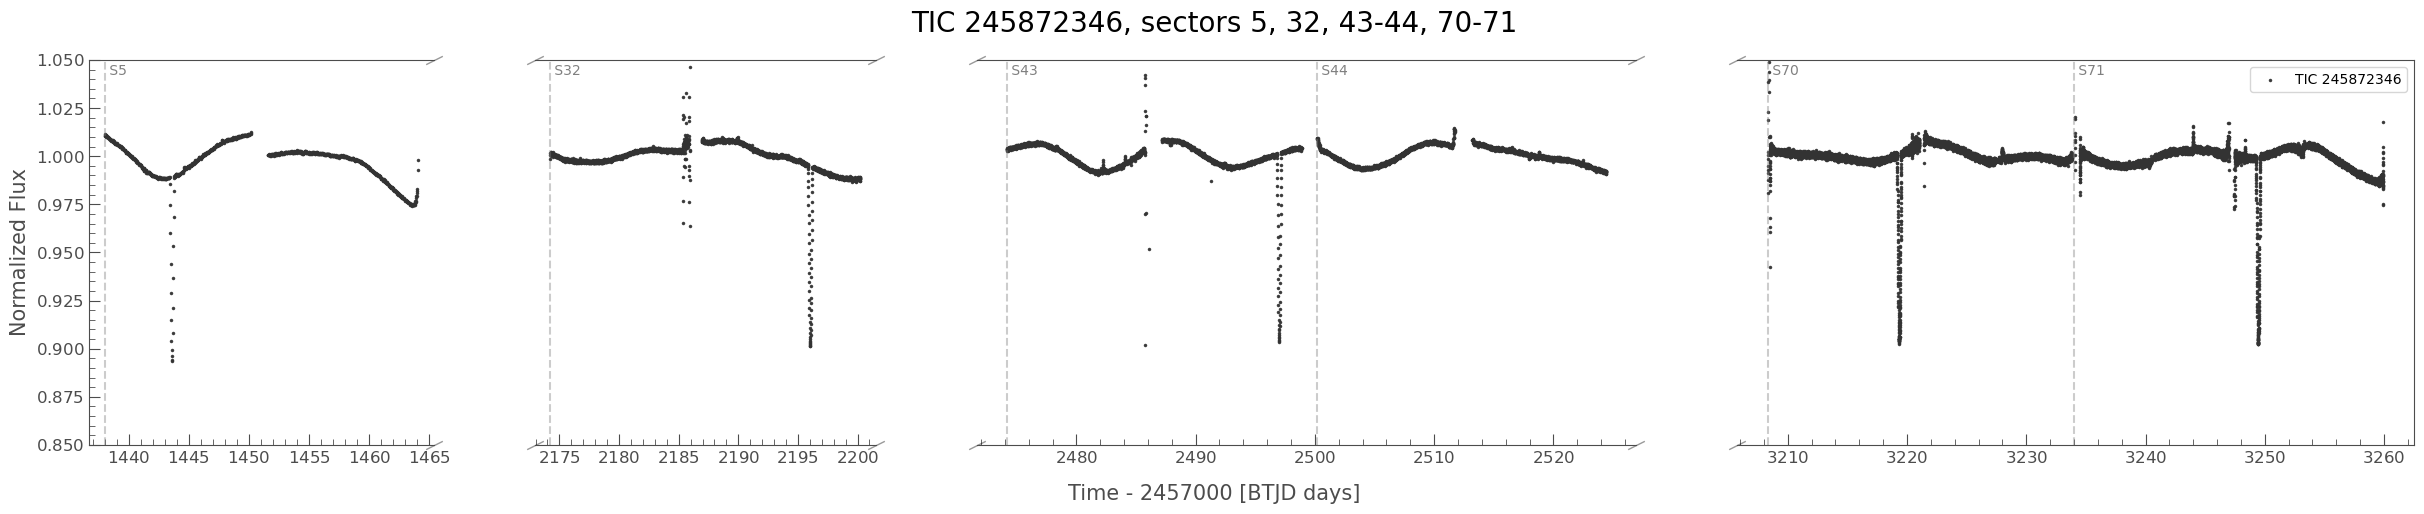

In [11]:
lc = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True,)  # corrector_func=lambda lc: lc.select_flux("sap_flux").normalize()

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=9, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);
[ax.set_ylim(0.85, 1.05) for ax in axs];

### Comparing QLP data used with SPOC data 
- except sector 5 (QLP only)

QLP (Sector 5) + SPOC PDCSAP_FLUX:
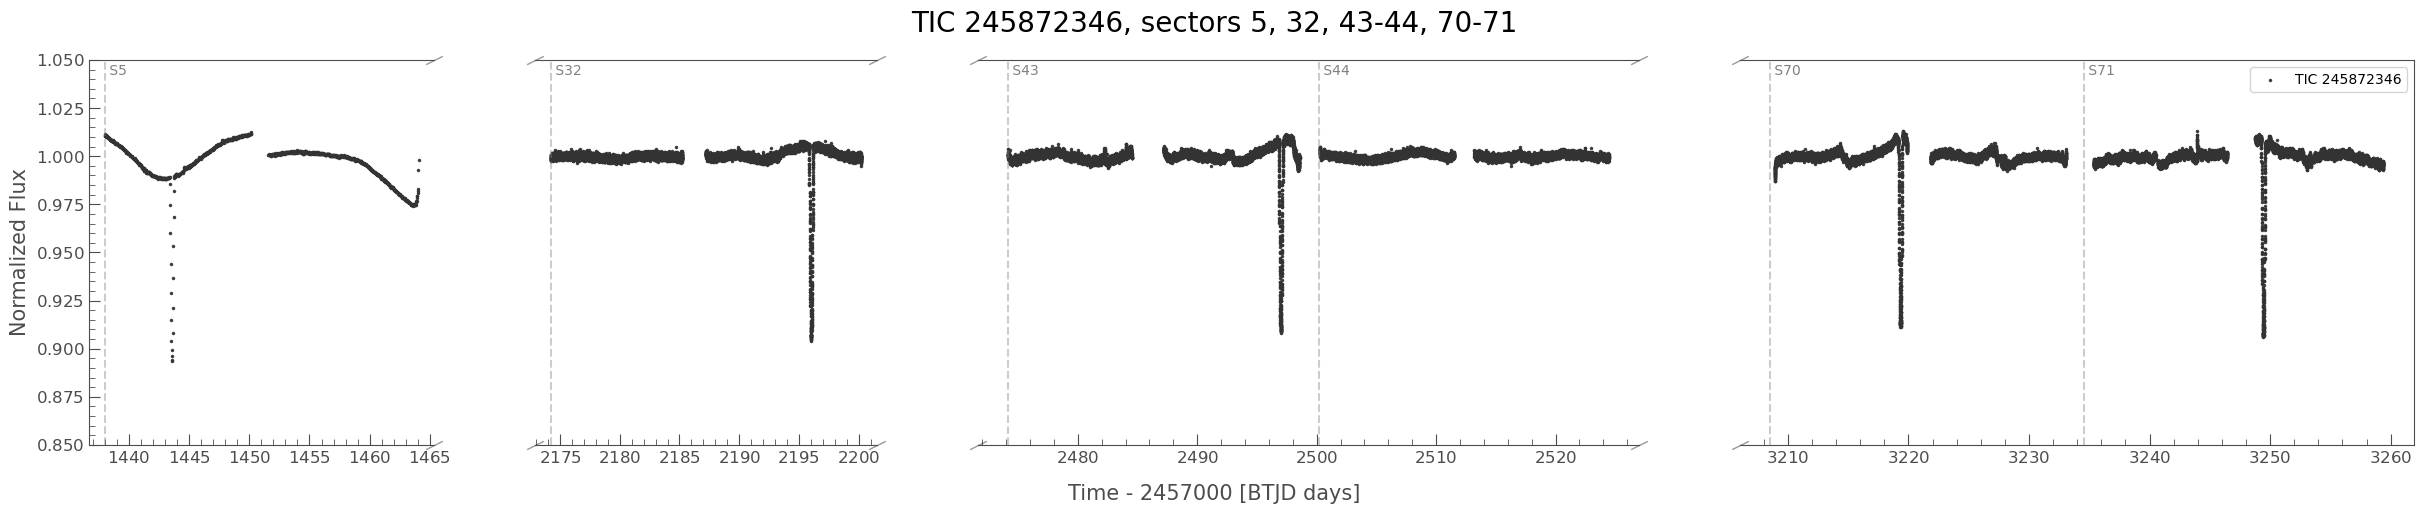

QLP (Sector 5) + SPOC SAP_FLUX:
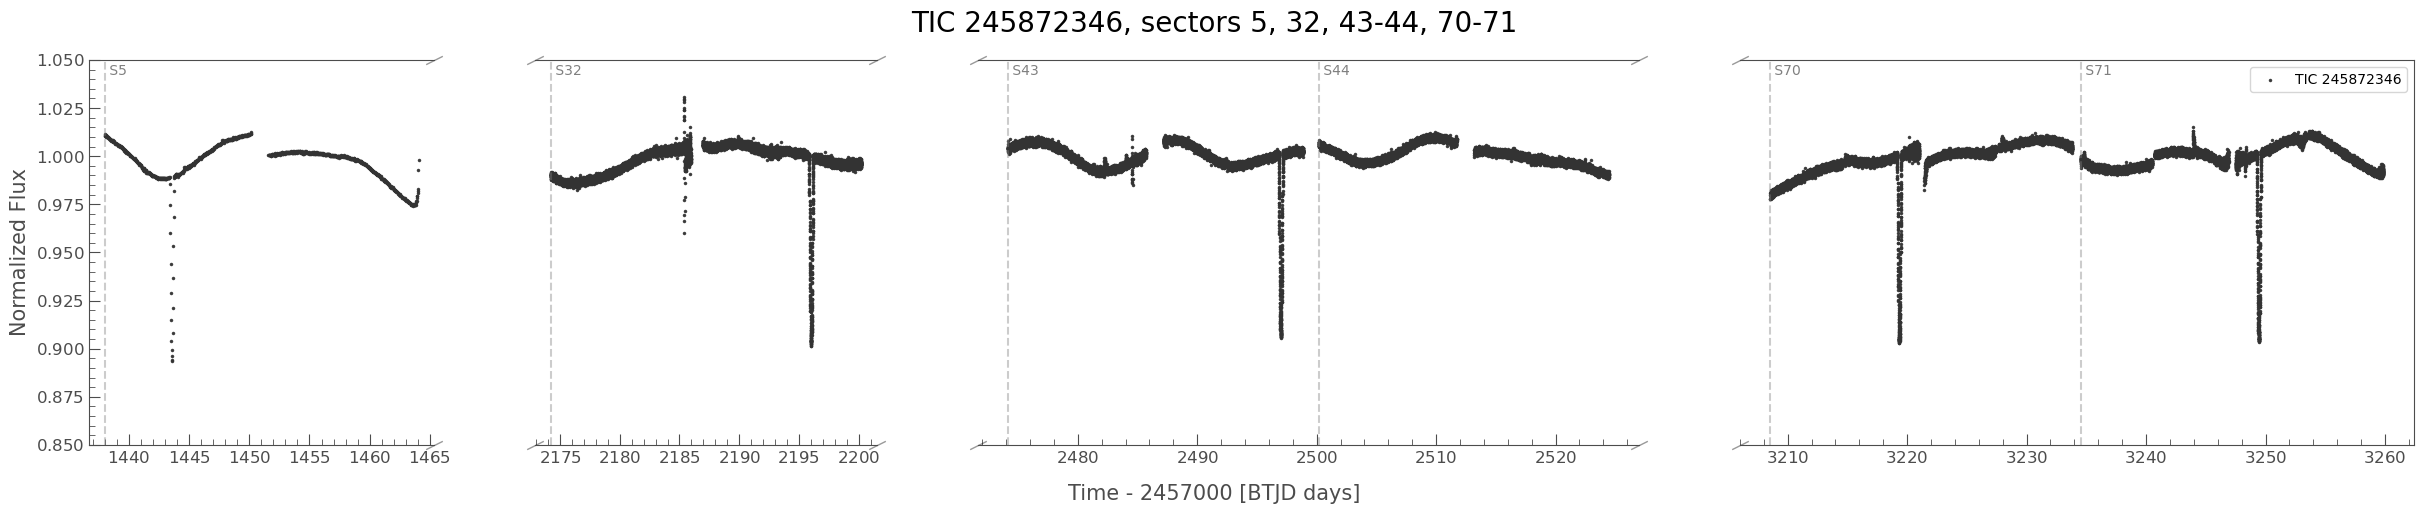



### Out of eclipse variability

Out of eclipse variability seen in QLP (and often distorted in SPOC PDCSAP_FLUX), appear to be genuine and is proably on target. E.g., 

The last half of sector 43 lightcurve at pixel level: 

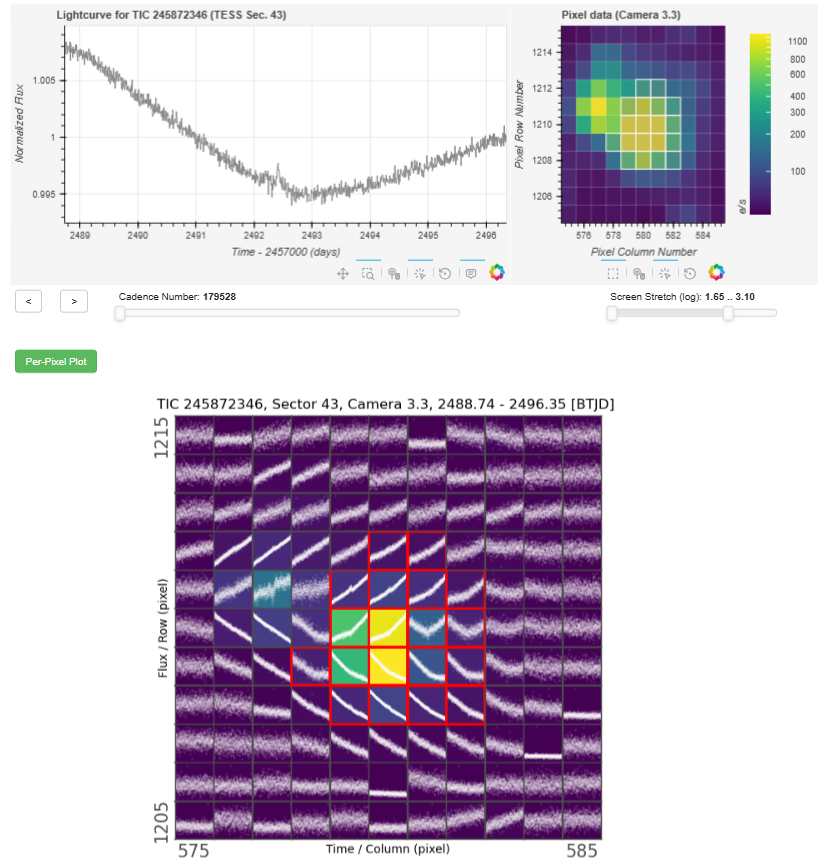

---

The first half of sector 44 lightcurve at pixel level: 

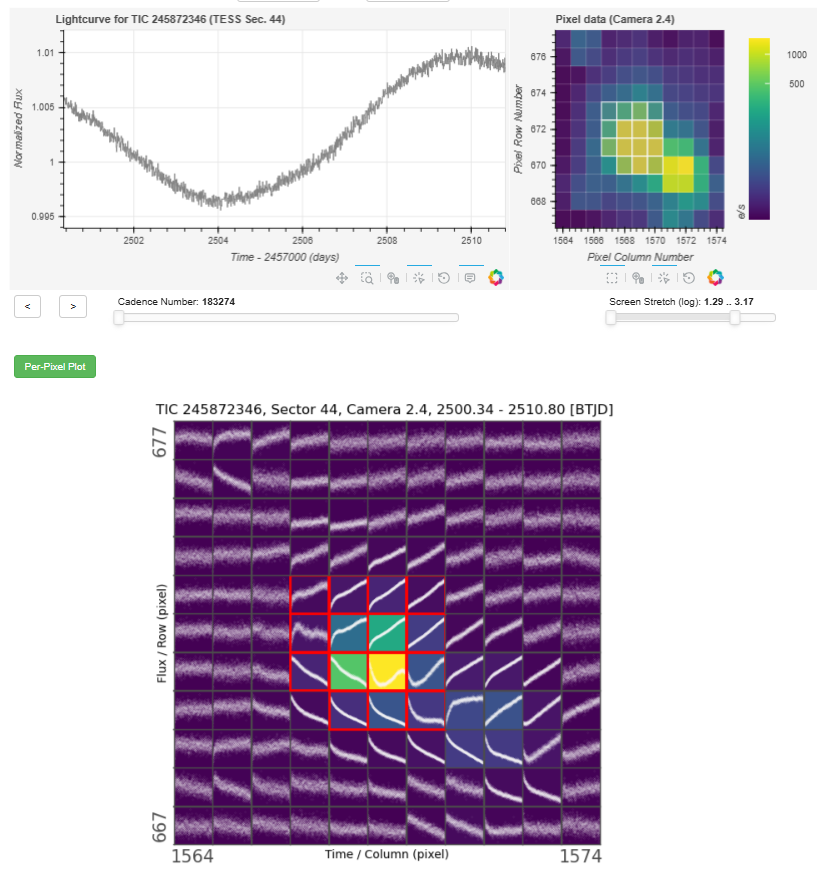

---

The last half of sector 71 lightcurve at pixel level: 

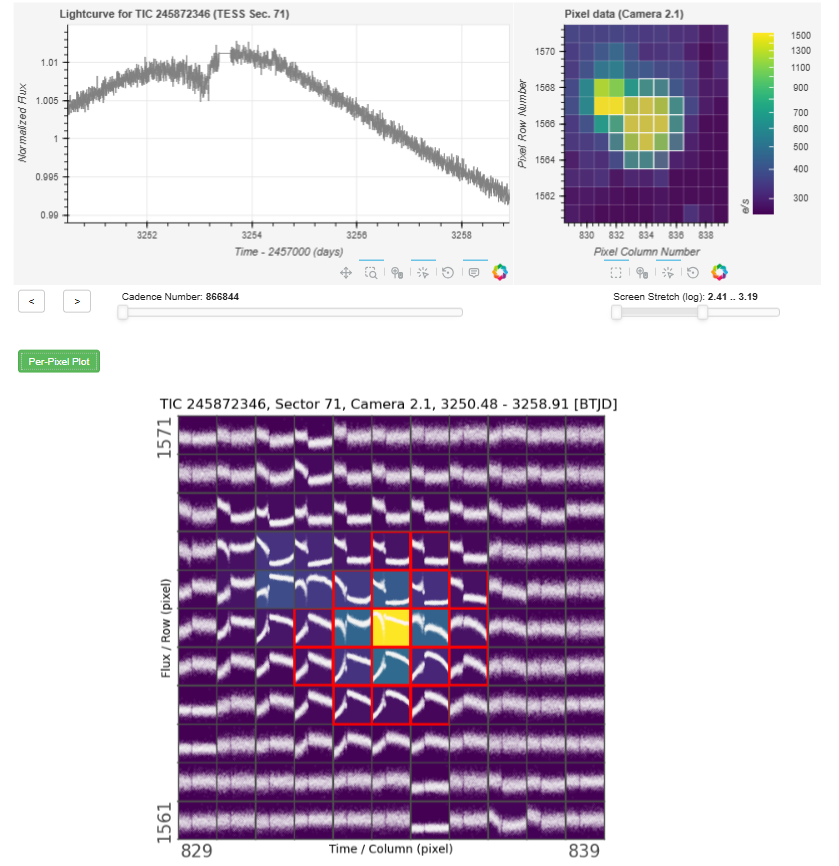


There is a lone flare near BTJD 3243.93, that seems to be on target: 

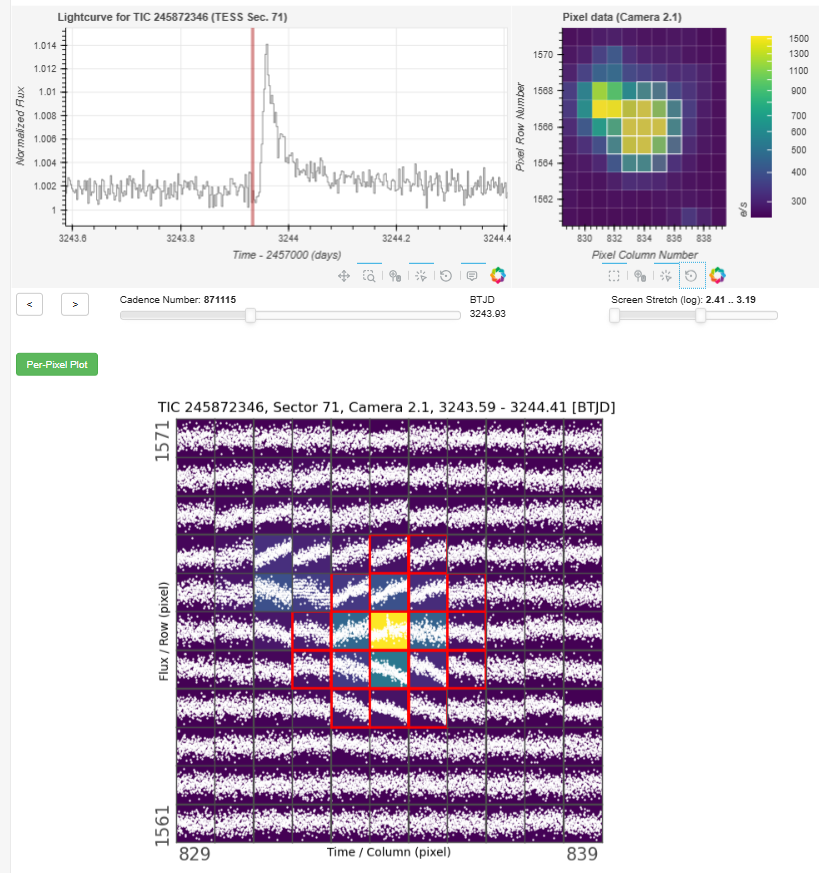


## Gaia DR3 info (coordinate, etc.)

In [33]:
# reload(lke)
# reload (lket)
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic, radius_arcsec=15, magnitude_range=None,  pm_error_factor=None, pm_range_fraction=None, pm_range_minimum=None, 
                                                        calc_separation_from_first_row=True,  # assuming the first row is the target, it'd calculate more accurately the separation for Gaia DR3 Main
                                                        compact_columns=True, also_return_html=True, also_return_astrophysical=False, verbose_html=True, include_nss_summary_in_html=False)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)


The target is also listed as an AB and SB with ~500 dperiod in [Gaia DR3 NSS](https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-source=I/357&-c=17%3A55%3A59.25%20%2B45%3A52%3A26.42&-c.u=arcsec&-c.r=15&-c.eq=J2000&-out.add=_r&-out.add=_p&-sort=_r)


In [34]:
primary_name = f"TIC {tic}"
primary_name

'TIC 245872346'

## Combining all data

- Archival ASAS-SN, CRTS, Tycho-2 data exist, but they do not have the photometric precison needed:

http://asas-sn.ifa.hawaii.edu/skypatrol/objects/206159836178

http://nunuku.caltech.edu/cgi-bin/getcssconedb_release_img.cgi?RADec=68.96968+13.60072&Rad=0.2&DB=photcat&OUT=csv&SHORT=short&PLOT=plot

https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ63a724f430cc2&-out.add=.&-source=I/239/tyc_main&recno=58633&-out.all=1  , 
https://cdsarc.cds.unistra.fr/viz-bin/vizExec/Vgraph?I/239/&%20694%20%20%20877%201

### ASAS-3


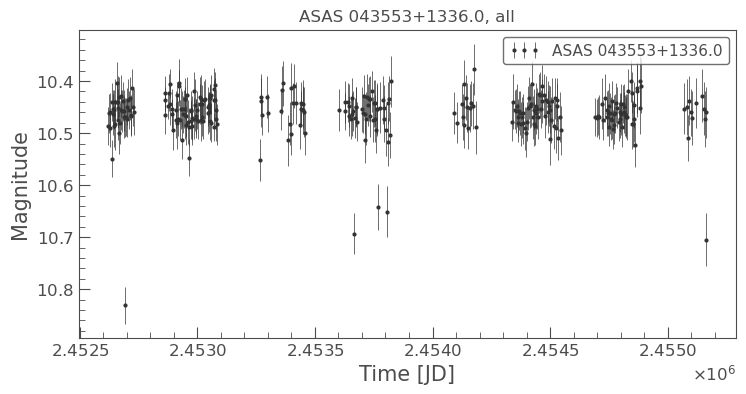

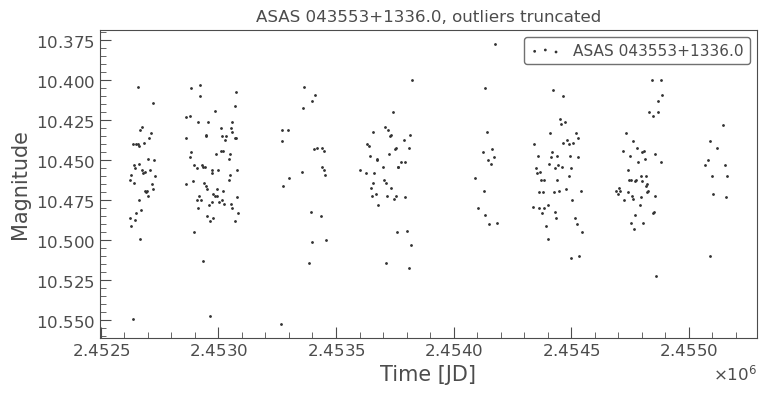

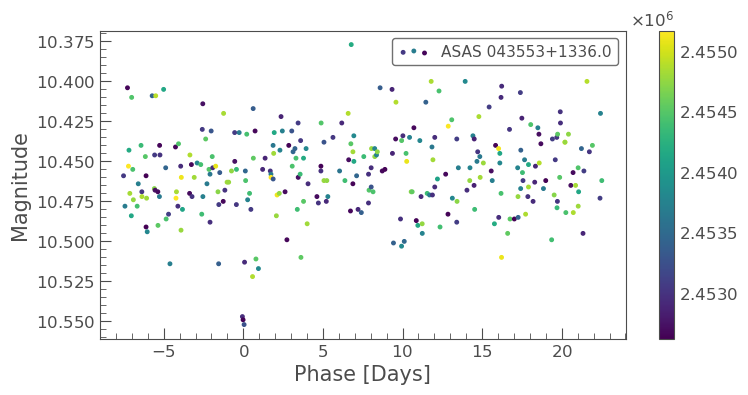

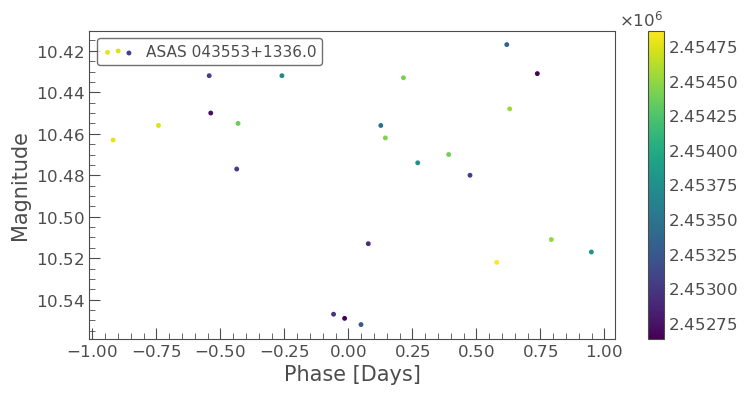

In [39]:
import lightkurve_ext_readers as lker

# https://www.astrouw.edu.pl/cgi-asas/asas_variable/043553+1336.0,asas3,0,0,500,0,0
_lc = lker.read_asas3("https://www.astrouw.edu.pl/cgi-asas/asas_cgi_get_data?043553+1336.0,asas3")

# _lc = lke.to_flux_in_mag_by_normalization(_lc, base_mag=11.17363)  # from SuperWASP
ax = tplt.errorbar(_lc);
ax.set_title(_lc.label + ", all");

_lc = _lc.truncate(None, 10.6, column="flux")   # remove isolated faint outliers 
# ax = tplt.errorbar(_lc);
ax = tplt.scatter(_lc);
ax.set_title(_lc.label + ", outliers truncated");

_lc_f = _lc.fold(period=30.09762, epoch_time=Time(2196.0248, format="btjd").to_value("jd"), wrap_phase=30.09762*0.75)  # rough initial epoch / period to gauge usefulness of the data
ax = tplt.scatter(_lc_f, s=25, c=_lc_f.time_original.value);

_lc_f_t = _lc_f.truncate(-1, 1)
ax = tplt.scatter(_lc_f_t, s=25, c=_lc_f_t.time_original.value);

lc_asas3 = _lc

In [53]:
# Consider whether ASAS-3 V mag needs to be calibrated: leave it alone for now
( 
    np.nanmedian(lc_asas3.flux.value), 
    10.43,  # Vmag derived from Gaia DR3 
    10.48,  # Vmag derived from Tycho-2 from SIMBAD, error: 0.06
    # no GCPD value
)

(10.456, 10.43, 10.48)

### TESS: remove systematics / outliers, convert to mag and HJD

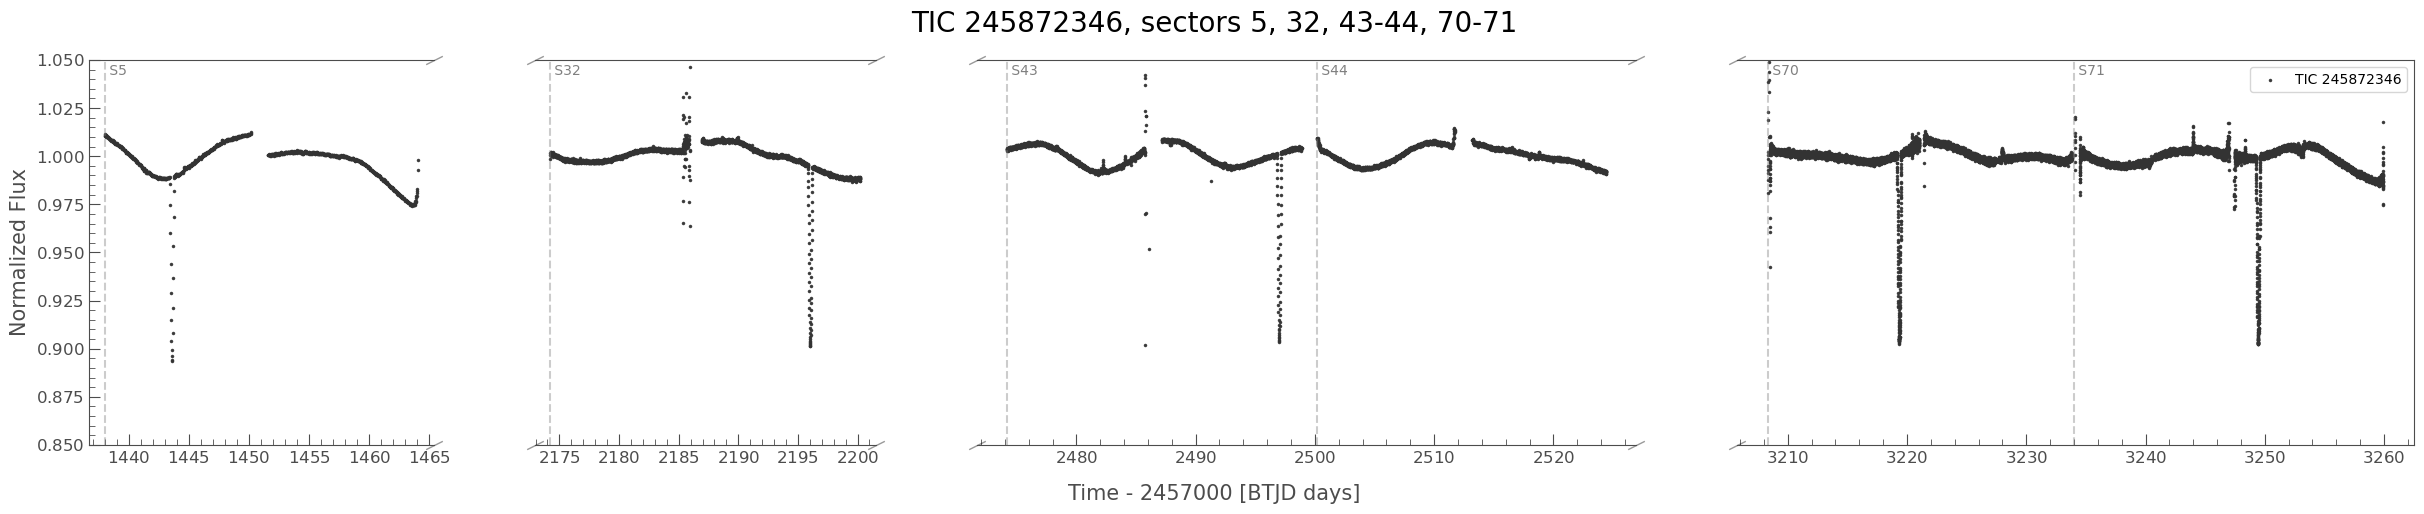

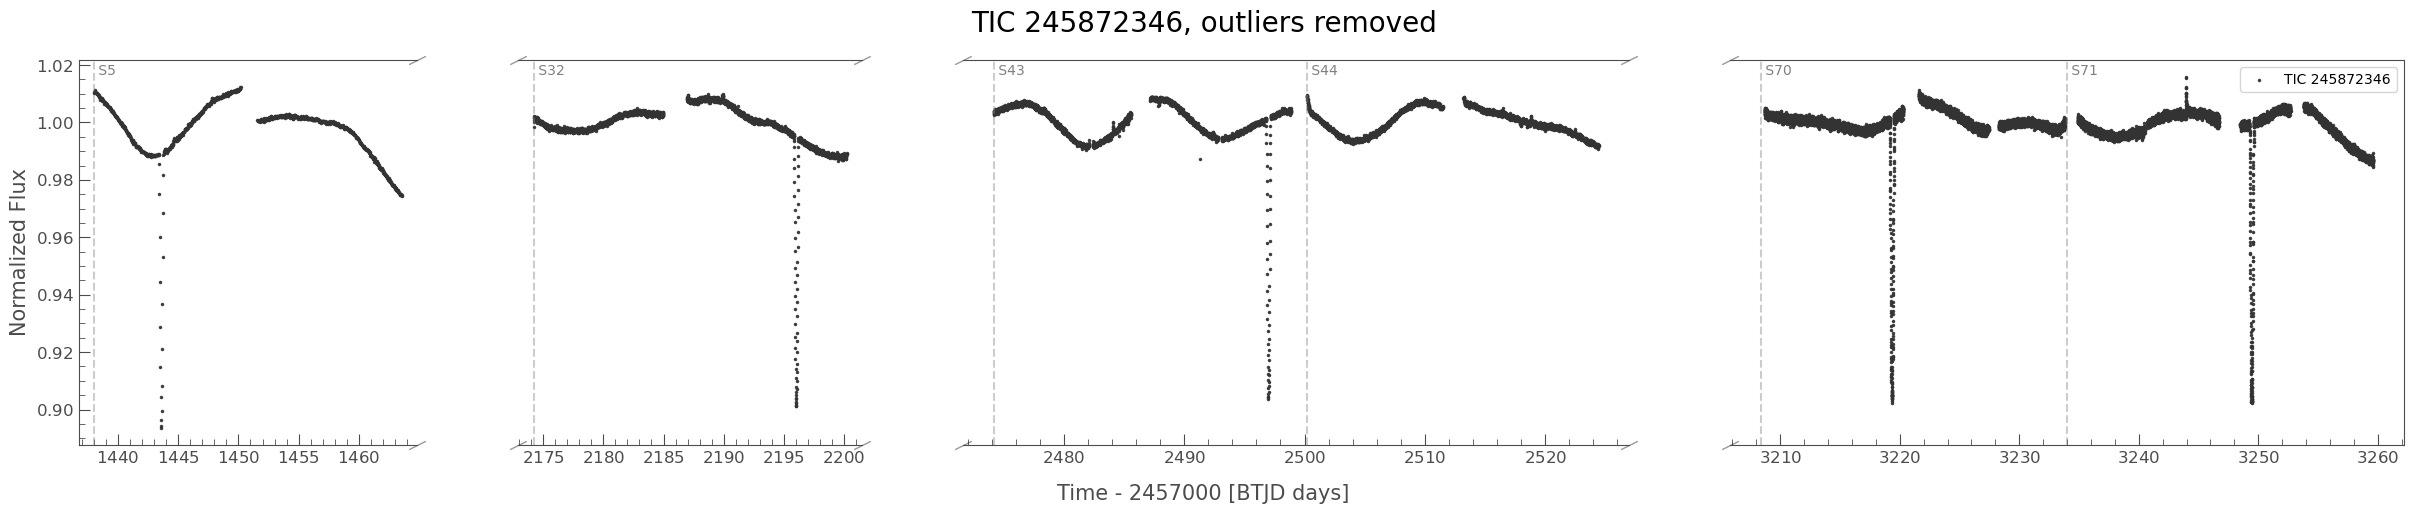

In [88]:
_lc = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True,)  # corrector_func=lambda lc: lc.select_flux("sap_flux").normalize()
# _lc_all = _lc  # retain a copy
axs = tplt.plot_skip_data_gap(_lc, figsize=(30,5), s=9, alpha=0.9);
axs[0].get_figure().suptitle(f"{_lc.label}, sectors {lke.abbrev_sector_list(_lc)}", fontsize=20);
[ax.set_ylim(0.85, 1.05) for ax in axs];

# remove outliers, do it in BTJD as it's more familiar to me

_lc = _lc.truncate(0.85, 1.05, column="flux")  #curde way to remove extreme ouliters
for xstart, xstop in [  # scattered light, and systematics (usually momentum dumps related)
    (1463.6, 1464.2), 
    (2185, 2186),
    (2482.1, 2482.4), 
    (2485.6, 2486.2),
    (2492.8, 2493.1), 
    (2511.5, 2511.8), 
    (3208.2, 3208.7),
    (3220.3, 3221.6), 
    (3227.5, 3228.3), 
    (3234.0, 3234.9), 
    (3246.7, 3248.5), 
    (3252.7, 3253.8),
    (3259.6, 3260.1), 
]:
    _lc = lke.exclude_range(_lc, xstart, xstop)
    
axs = tplt.plot_skip_data_gap(_lc, figsize=(30,5), s=9, alpha=0.9);
axs[0].get_figure().suptitle(f"{_lc.label}, outliers removed", fontsize=20);


# convert to mag and HJD
lc_tess = _lc
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)
lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)



### Do Actual combining

TESS # data points: 30148
ASAS-3 # data points: 299


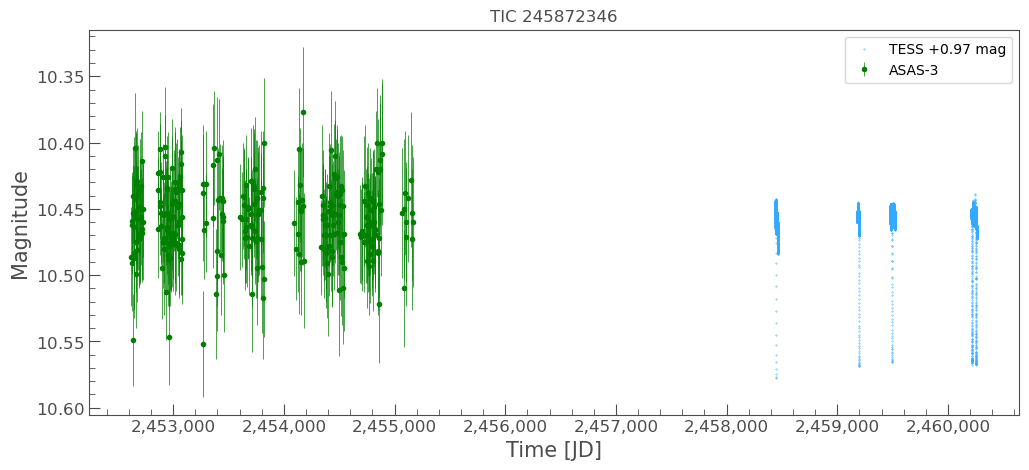

In [89]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
# reload(lkem)

# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
     "ASAS-3": lc_asas3,
    }, 
    shift_to="ASAS-3",

)

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) move it to the front
# plot_options[0][1]["zorder"] = 3  # default 2

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name, plot_options=plot_options);
# ax.set_ylim(15.2, 14.0);

## Final eclipse epoch / period / duration

- epoch / period / duration  from TCE

https://exo.mast.stsci.edu/exomast_planet.html?planet=TIC245872346S0002S0072TCE1  , 
https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2018235142541-s0002-s0072-0000000245872346-01-00829_dvs.pdf

Adopted period / epoch / duration_hr:  30.0976 2459196.024 8.89


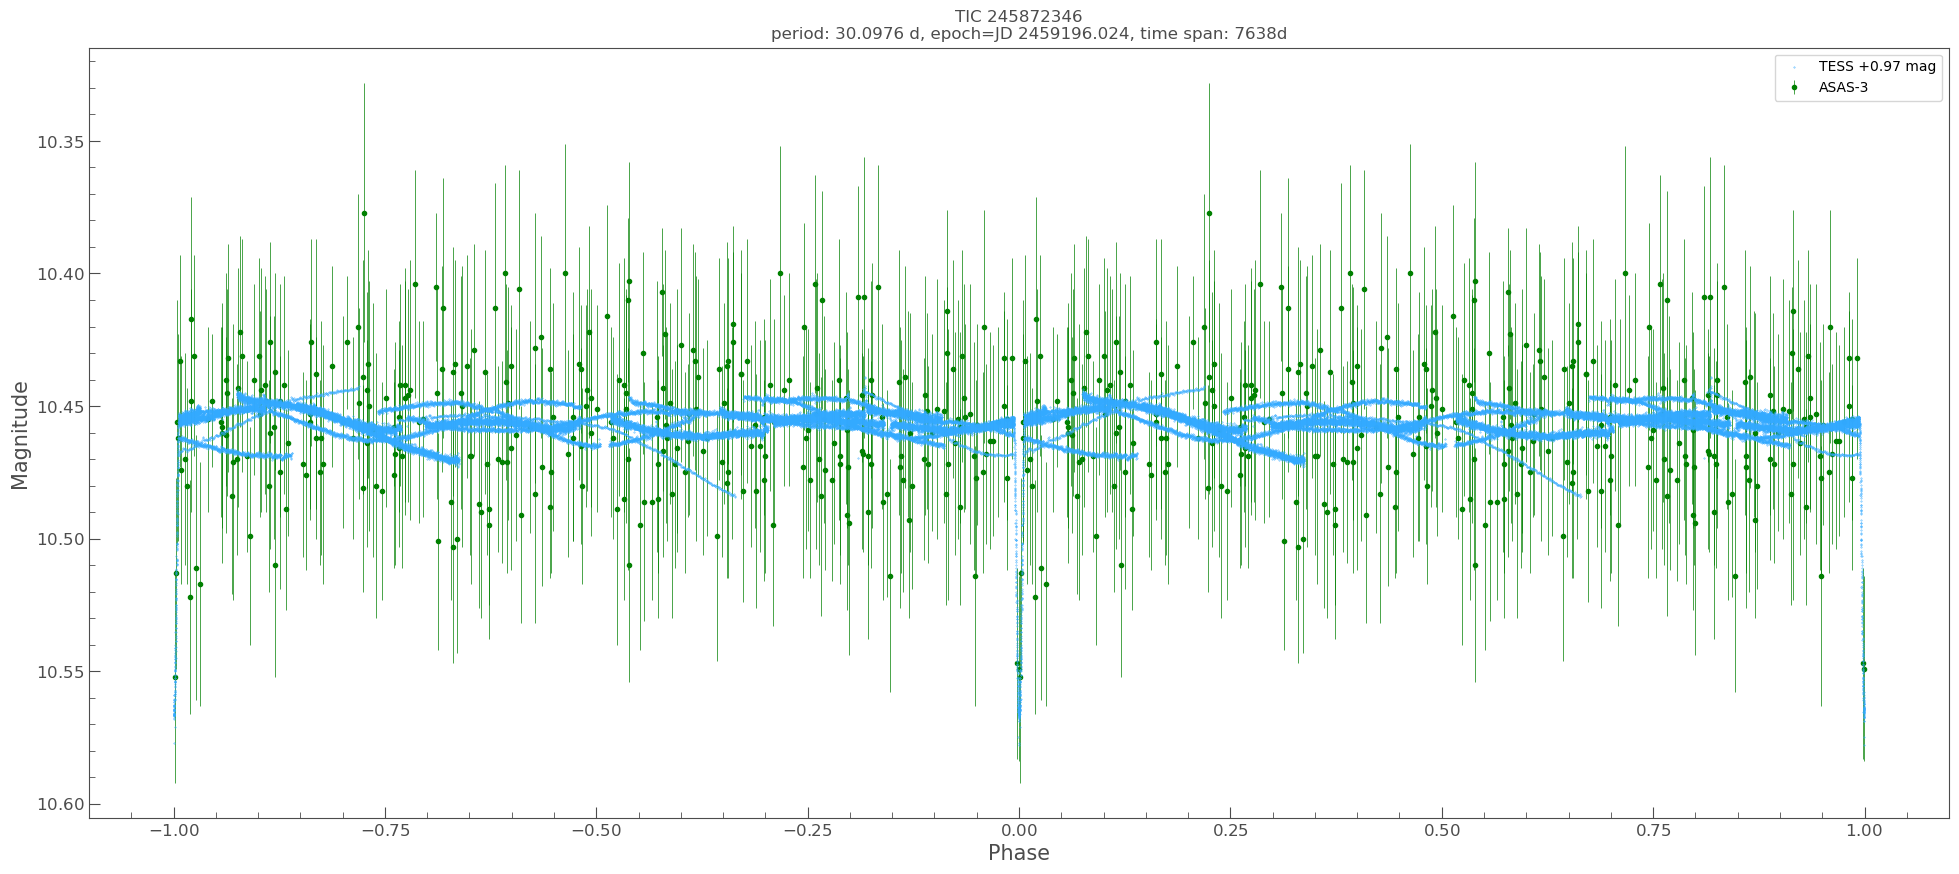

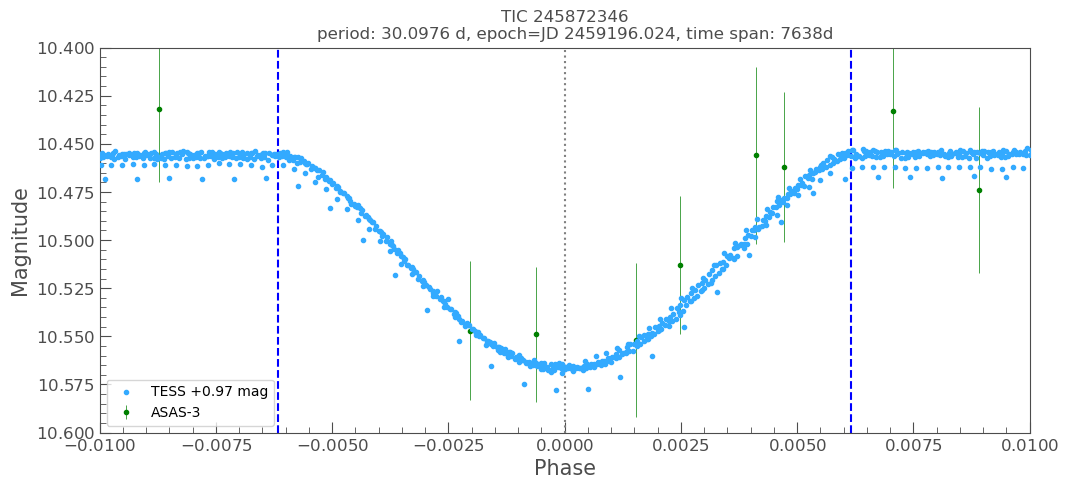

In [56]:
period_final = 30.0976   # rounded from: 30.09762
epoch_time_btjd_final = 2196.0248
epoch_time_hjd_final = round(lket.btjd_to_hjd_utc(epoch_time_btjd_final, target_coord), 3)  # 2 digit is probably sufficient

duration_hr_min_i_final = 8.89


print("Adopted period / epoch / duration_hr: ", period_final, epoch_time_hjd_final, duration_hr_min_i_final)

# --- Plot them to verify ---

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) move it to the front
plot_options[0][1]["zorder"] = 3  # default 2

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);


# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 9
plot_options_zoom[0][1]["zorder"] = 3  # move to the front, default 2

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,
);
ylim = (10.6, 10.4)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.01, 0.01);  # to see primary in details


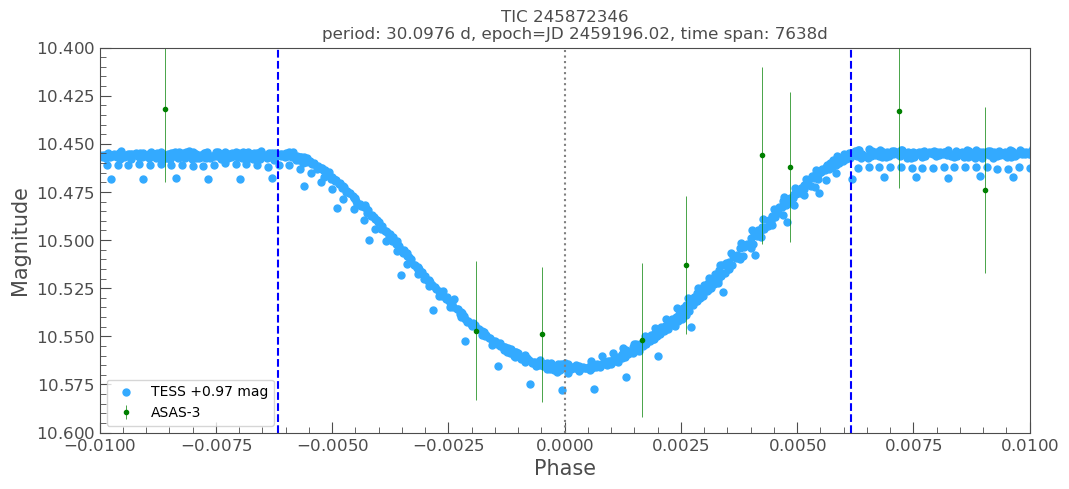

In [55]:
# demonstrate the differnce if Min I epoch is in 2 digits instead of 3 digits

_et = round(epoch_time_hjd_final, 2)
# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 25
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(_et  , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.01, 0.01);  # to see primary in details


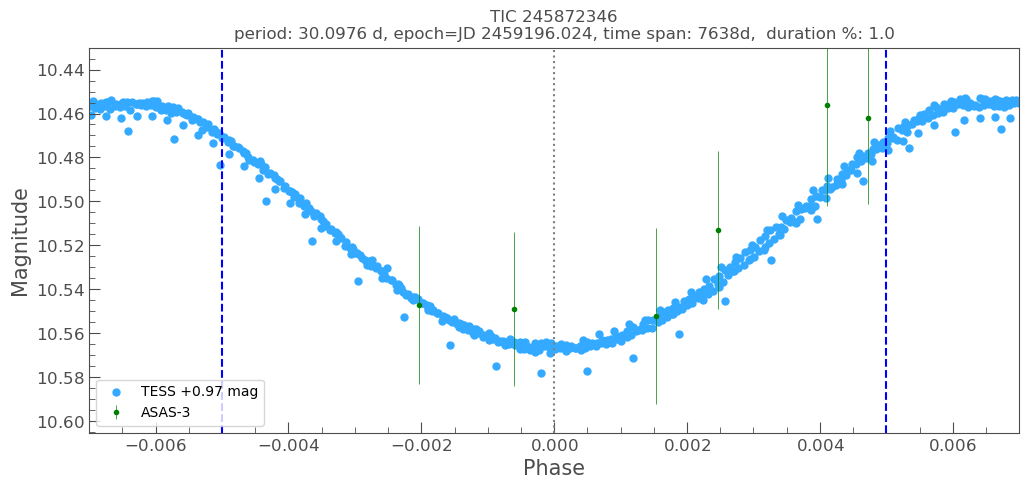

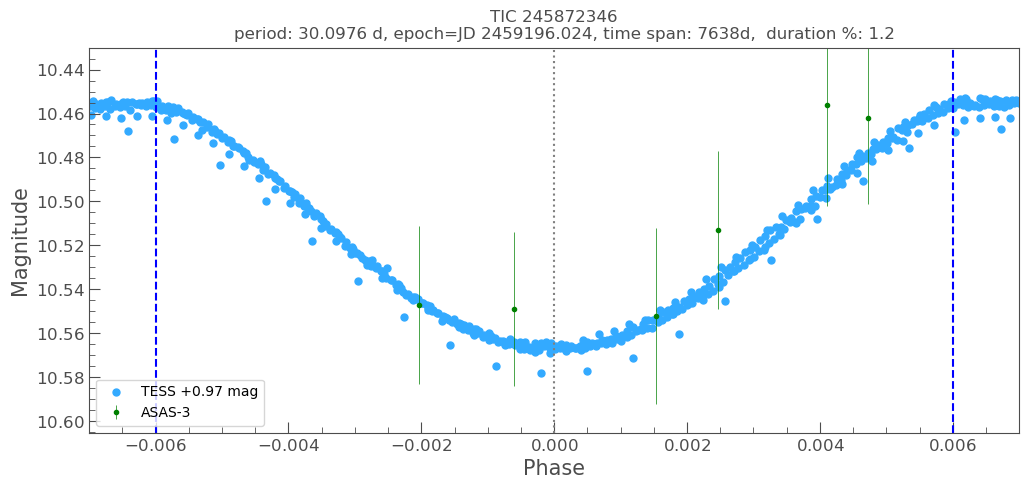

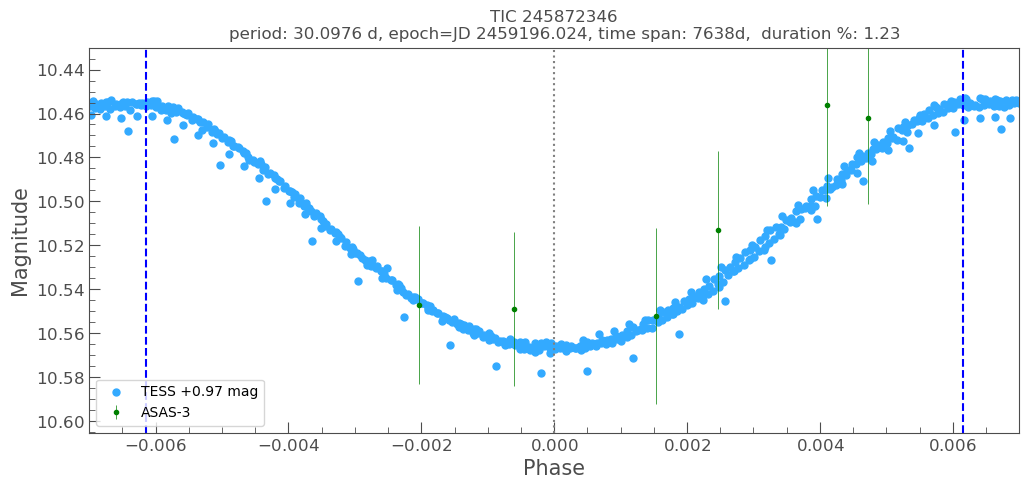

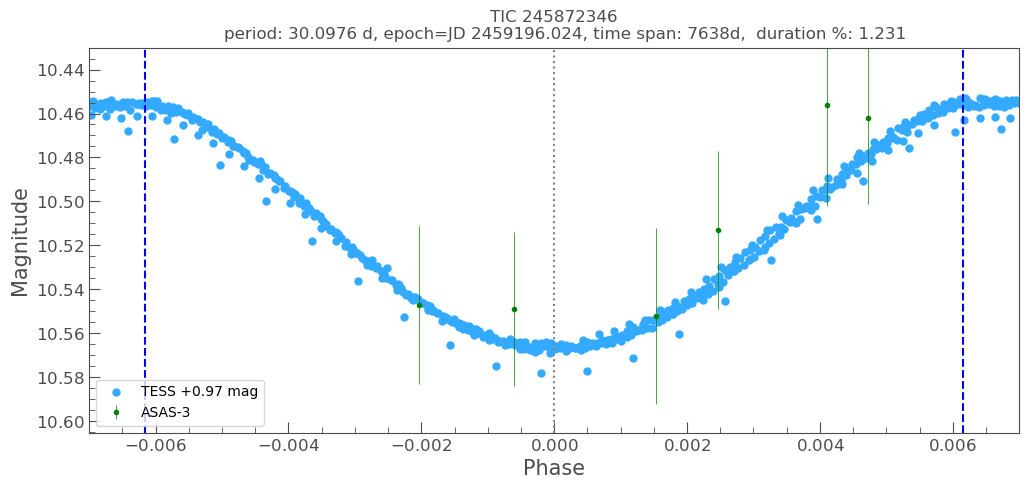

In [216]:
# demonstrate the precision difference in duration percentage 

for _precision in [0, 1, 2, 3]:  # 1 decmila  point is sufficient
    _dur_pct = round(100 * duration_hr_min_i_final / 24 / period_final, _precision)
    _dur_hr = _dur_pct /100 * 24 * period_final
    # zoom plot Min I
    # - make TESS more visible:  larger dots
    plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
    plot_options_zoom[0][1]["s"] = 25
    ax, lc_f_res = lkem.fold_n_plot_multi_bands(
        lc_combined_dict,
        period=period_final,
        epoch=Time(epoch_time_hjd_final  , format="jd", scale="utc"),
        phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
        target_name=primary_name,
        duration_hr=_dur_hr,  # for plotting only
        figsize=(12, 5),
        plot_options=plot_options_zoom,
        # mag_shift_precision=2,  #
    );
    ax.set_ylim(*ylim);
    ax.legend(loc="lower left");
    ax.axvline(0, c="gray", linestyle="dotted");
    ax.set_xlim(-0.007, 0.007);  # to see primary in details
    ax.set_title(ax.get_title() + f",  duration %: {_dur_pct}");
    # print(_dur_pct, _dur_hr, duration_hr_min_i_final) 

## Rotational Epoch / Period

#### Initial ROT epoch / period

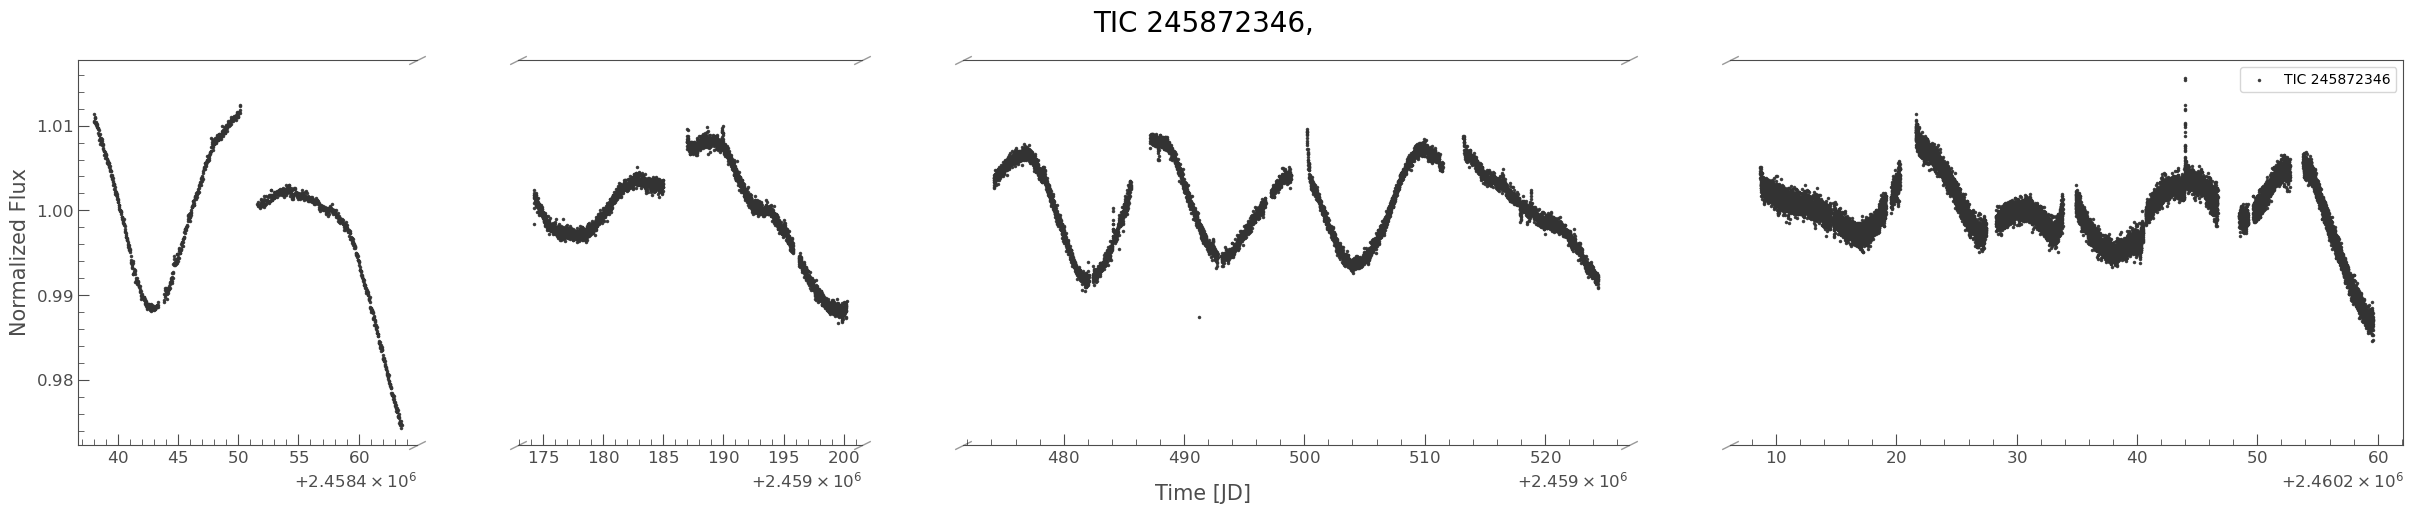

In [113]:
_lc = lc_combined_dict["TESS"]
tmask = _lc.create_transit_mask(period=period_final, transit_time=epoch_time_hjd_final, duration=1.2 * duration_hr_min_i_final / 24)
_lc = _lc[~tmask]
_lc = lke.to_normalized_flux_from_mag(_lc)

axs = tplt.plot_skip_data_gap(_lc, figsize=(30,5), s=9, alpha=0.9);
axs[0].get_figure().suptitle(f"{_lc.label}", fontsize=20);


In [104]:
pg = _lc.to_periodogram(method="lombscargle")  # oversample_factor=5
pg.show_properties();
print("period_at_max_power:", pg.period_at_max_power, "/", pg.period_at_max_power.to(u.h),"/", pg.frequency_at_max_power.to(u.microhertz))

lightkurve.Periodogram properties:
      Attribute          Description    Units
---------------------- ---------------- -----
                nterms                1      
              targetid        245872346      
          default_view        frequency      
                 label    TIC 245872346      
             ls_method             fast      
frequency_at_max_power            0.098 1 / d
             max_power           0.0039      
               nyquist         215.9827 1 / d
   period_at_max_power          10.1993     d
             frequency array (1967173,) 1 / d
                period array (1967173,)     d
                 power array (1967173,)      
                  meta   <class 'dict'>      
period_at_max_power: 10.19934610302288 d / 244.7843064725491 h / 1.1347858928567738 uHz


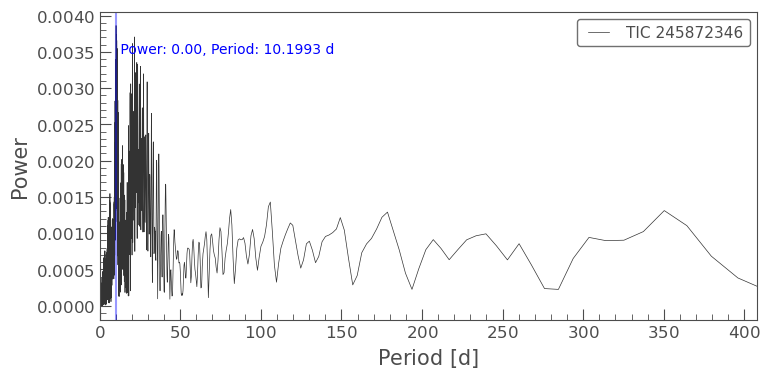

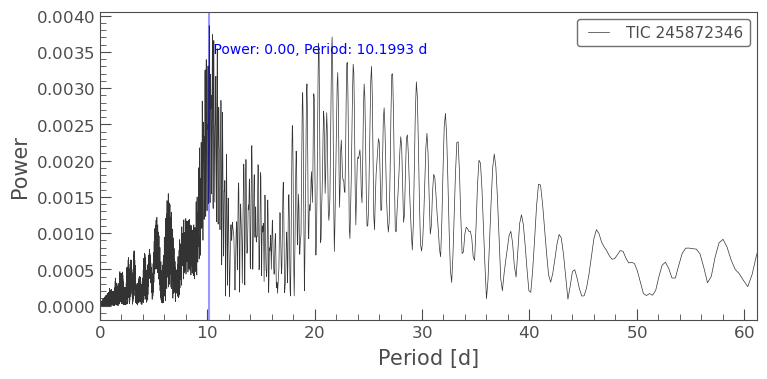

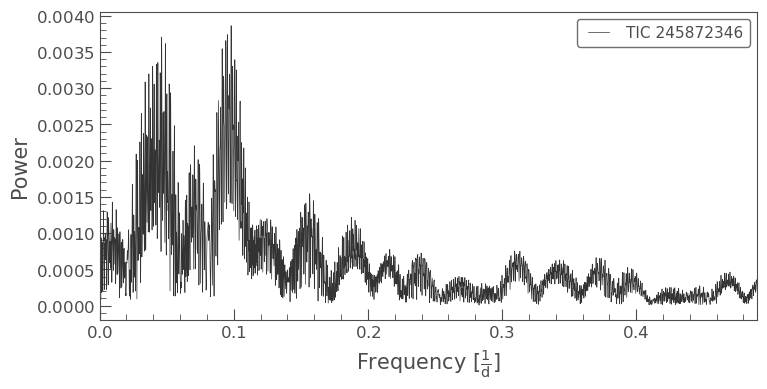

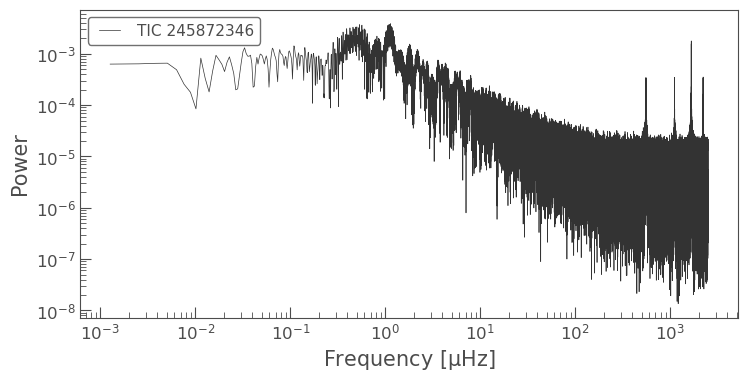

In [105]:
ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=40);
# ax.set_xlim(0, 16);

# zoom in
ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=6);

# ---

ax = pg.plot(view="frequency");  # frequency view
ax.set_xlim(0 , pg.frequency_at_max_power.value * 5);
# ax.set_xlim(0, 5);

# frequency in log scale / microhertz
# often useful for solar type oscillator, 
ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");  
# the smoothed plot is useful for repsresenting convective background (that scientists usually want to filter out)
# smooth_pg = pg.smo7oth(method='logmedian', filter_width=0.1)
# smooth_pg.plot(ax=ax, linewidth=2,  color='red', label='Smoothed (bkg)', unit=u.microhertz, scale='log');
# ax.axvline(50.31207607657116, ymax=0.2, color="blue", linestyle="--", label="~50 uHz "); ax.legend();


plt.show(ax.get_figure())
display(HTML(""" <a href="https://docs.lightkurve.org/tutorials/3-science-examples/asteroseismology-oscillating-star-periodogram.html" target="_oscillator_lk_pg">Oscillator Periodogram from Lightkurve</a> """))

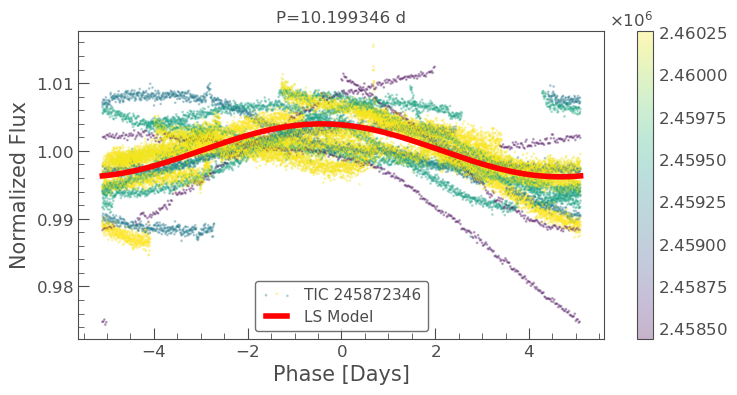

In [106]:
# reload(lke_pg)
axs, lcs = lke_pg.plot_lc_with_model(
    _lc.normalize(),
    pg, 
    # period=9.35477318054611 * u.d,
    plot_lc=False, plot_model=False, plot_folded_model=True, 
    # plot_folded_model_with_time_cmap=False,
    also_return_lcs=True);
axs[-1].set_title(f"P={lcs.lc_f.period:.6f}");
# [ax.set_ylim(0.99, 1.01) for ax in axs];

In [116]:
lc_combined_dict_no_ecl = dict()
for key, _lc in lc_combined_dict.items():
    tmask = _lc.create_transit_mask(period=period_final, transit_time=epoch_time_hjd_final, duration=duration_hr_min_i_final/24 * 1.2)
    _lc = _lc[~tmask]
    lc_combined_dict_no_ecl[key] = _lc

list(lc_combined_dict_no_ecl.keys())

['TESS', 'ASAS-3']

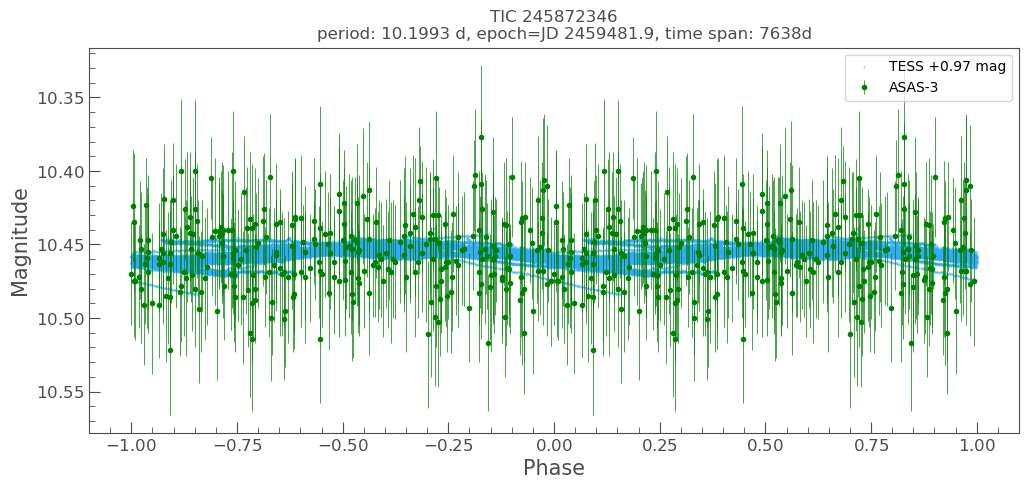

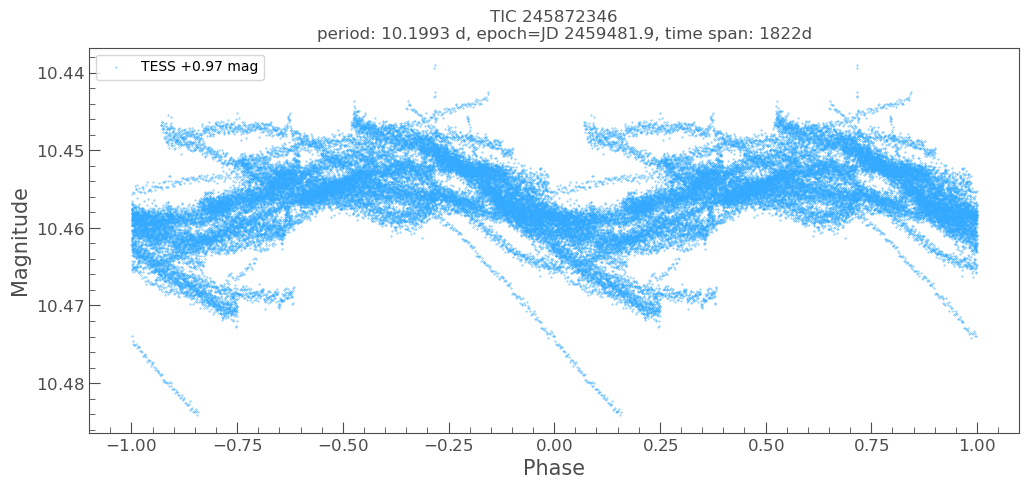

In [143]:
rot_period_trial , rot_epoch_time_hjd_trial = 10.1993, round(lket.btjd_to_hjd_utc(2481.9, target_coord), 1)   # from LS Periodgram / visual inspection respectively


ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_no_ecl, 
    period=rot_period_trial,
    epoch=Time(rot_epoch_time_hjd_trial, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(12, 5),
    target_name=primary_name,
    plot_options=plot_options,
);


ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    {"TESS": lc_combined_dict_no_ecl["TESS"]},  # avoid scatter in ASAS-3
    period=rot_period_trial,
    epoch=Time(rot_epoch_time_hjd_trial, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(12, 5),
    target_name=primary_name,
    plot_options=plot_options,
);

#### Refine the ROT period with MCMC


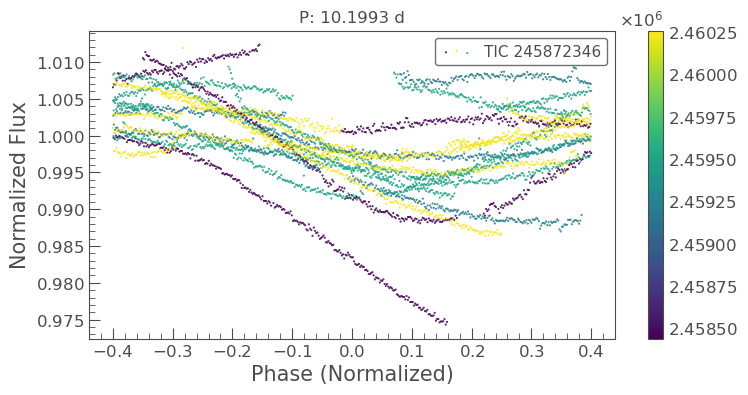

In [122]:
# _lc = lke.to_normalized_flux_from_mag(lc_combined_dict_no_ecl["TESS"].remove_nans())
_lc_binned = lke.bin_flux(lc_combined_dict_no_ecl["TESS"], time_bin_size=30*u.min)   # bin the data 30min , to make MCMC run faster
_lc = lke.to_normalized_flux_from_mag(_lc_binned.remove_nans().remove_nans(column="flux_err"))

_lc_f_rot_min_i = _lc.fold(epoch_time=rot_epoch_time_hjd_trial, period=rot_period_trial, normalize_phase=True)
_lc_f_rot_min_i = _lc_f_rot_min_i.truncate(-0.4, 0.4)
ax1 = tplt.scatter(_lc_f_rot_min_i, c=_lc_f_rot_min_i.time_original.value, s=1);
# ax1 = tplt.errorbar(_lc_f_rot_min_i);
ax1.set_title(f"P: {_lc_f_rot_min_i.period}");


In [121]:
from types import SimpleNamespace

import sys
if "../eb_with_diff_sb_period/etv/" not in sys.path:  # for etvp
    sys.path.append("../eb_with_diff_sb_period/etv/")

import etv_functions_with_period as etvp
import etv_functions
# reload(etv_functions)

lc_f = _lc_f_rot_min_i

# # median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# # t0 in normalized phase
start_vals = [1.0, -0.006, 0, 0.19, 1.1]

# convert lc to the form needed by fit etv_functions
lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))
etv_functions.plot_initial_guess_interactive(lc_f_data, None, None, None, "0", *start_vals)

Output(layout=Layout(padding='1em 0px'), outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Fig…

Output(layout=Layout(padding='1em'), outputs=({'name': 'stdout', 'text': '[1.0, -0.006, 0, 0.13, 1.1]\n\n', 'o…

100%|█████████████████████████████████████████████████████████████| 2000/2000 [04:40<00:00,  7.14it/s]
The chain is shorter than 20 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/20 = 100;
tau: [ 35.17807514  39.89874851 164.37651191  44.25178846  41.9111233
 146.18164473]


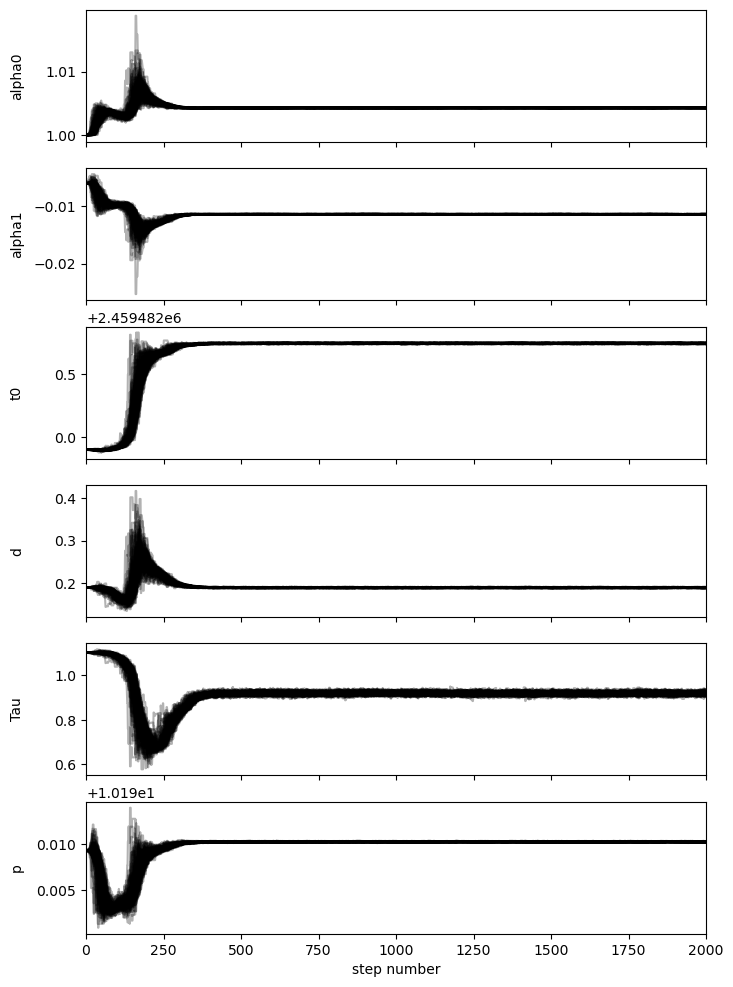

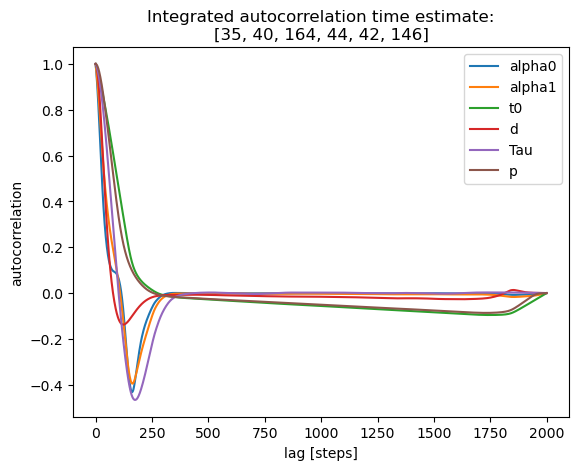

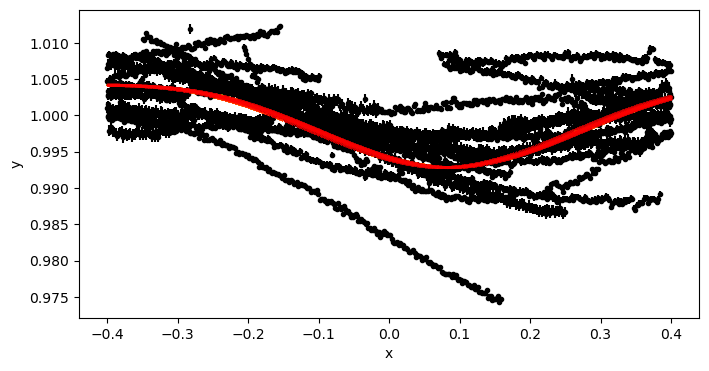

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0042776046567714, -0.011408335578770693, 2459482.7429908793, 0.18912865511127103, 0.9185927653189072, 10.200243773779983
std_t0: 0.0027208910496423415
std_p: 3.40262104702893e-05


In [124]:
mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats  = etvp.run_mcmc_initial_fit_p(
    lc_f_data, 
     [1.0, -0.006, rot_epoch_time_hjd_trial, 0.19, 1.1, rot_period_trial],
    # nruns=20, discard=1,
    # nruns=1000, discard=400,
    nruns=2000, discard=1000,
    autocorr_time_kwargs=dict(tol=20),  # the emcee defaults tol=50 seems to be too strict for our use case, tol of ~10 - 20 seems to be sufficient    
    pool=-2,
    plot_chains=True, plot_autocorrelation=True, plot=True, 
    also_return_stats=True,
)

print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
print("std_t0:", fit_params_p_stats["std_t0"])
print("std_p:", fit_params_p_stats["std_p"])


#### Final ROT epoch / period

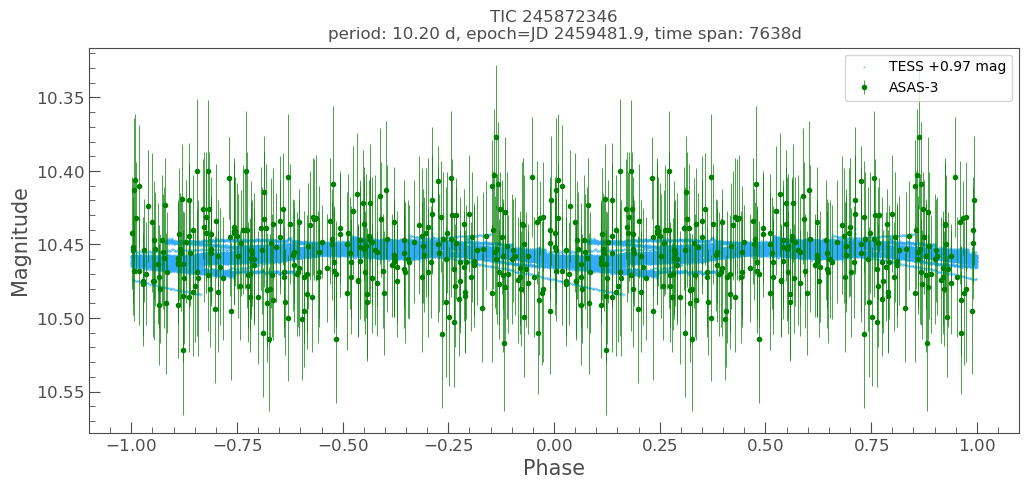

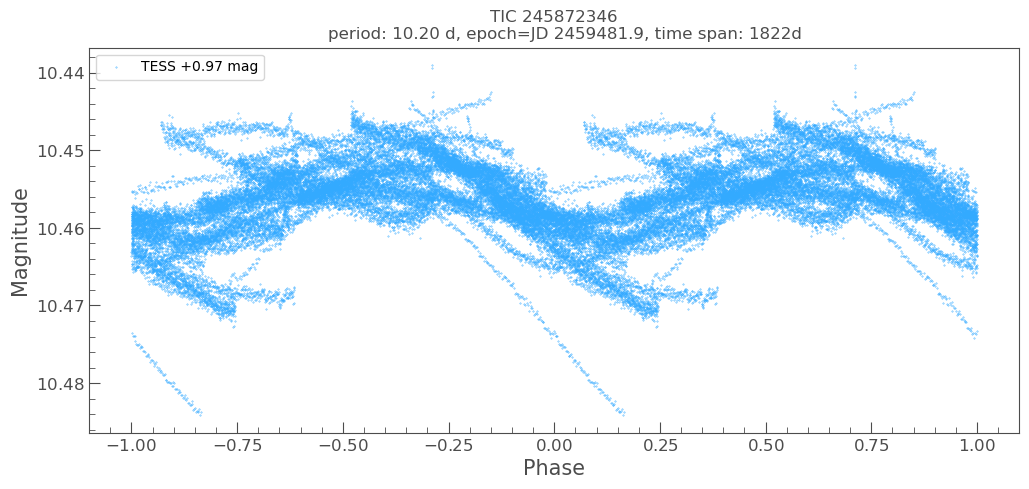

In [147]:
from decimal import Decimal

# MCMC: p=10.200243773779983,  std_p=3.40262104702893e-05, t0=2459482.7429908793, std_t0=0.0027208910496423415, t0 in btjd: ~2482.74
#
# use MCMC period but retain my inital epoch, in visual inspection, it fits better as the local minima
rot_period_final , rot_epoch_time_hjd_final = Decimal("10.20"), rot_epoch_time_hjd_trial


ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_no_ecl, 
    period=rot_period_final,
    epoch=Time(rot_epoch_time_hjd_final, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(12, 5),
    target_name=primary_name,
    plot_options=plot_options,
);

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    {"TESS": lc_combined_dict_no_ecl["TESS"]},  # avoid scatter in ASAS-3
    period=rot_period_final,
    epoch=Time(rot_epoch_time_hjd_final, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(12, 5),
    target_name=primary_name,
    plot_options=plot_options,
);

## Determine Magnitude Range / Amplitude


### Maximum V Magnitude (to be used in the main VSX table)

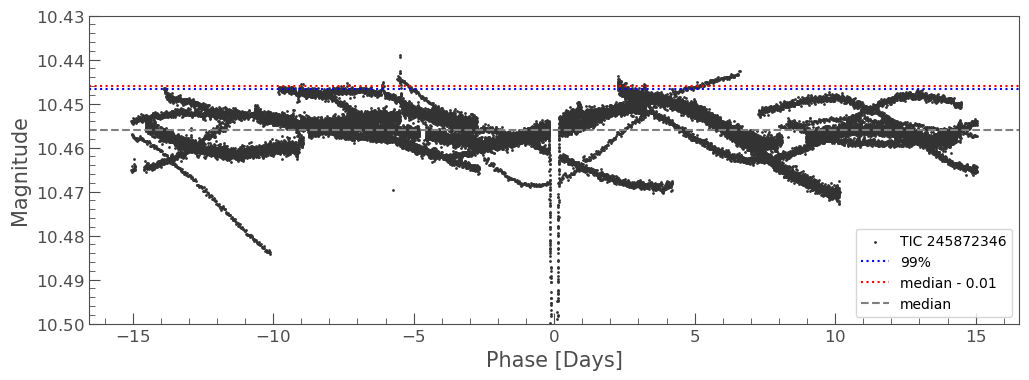

In [84]:
# In TESS band, max is roughly median - 0.01
_lc = lc_combined_dict["TESS"].fold(period=period_final, epoch_time=epoch_time_hjd_final);

ax = tplt.scatter(_lc, figsize=(12, 4));
ax.set_ylim(10.50, 10.43);
ax.axhline(np.nanpercentile(_lc.flux.value, 1), c="blue", linestyle="dotted", label="99%");
ax.axhline(np.median(_lc.flux.value) - 0.01, c="red", linestyle="dotted", label="median - 0.01");
ax.axhline(np.median(_lc.flux.value), c="gray", linestyle="--", label="median");

ax.legend();


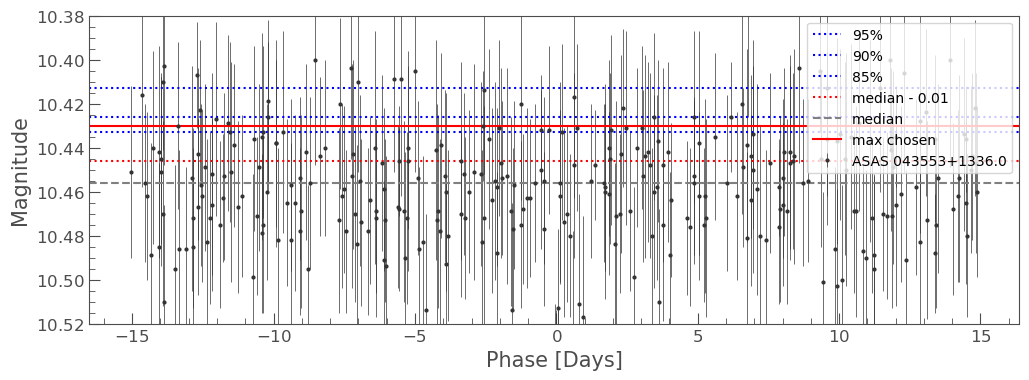

In [112]:
# In ASAS-3 with larger scatter, setting a max to median - 0.01 seems to be too small, even consideirng the scatter
_lc = lc_combined_dict["ASAS-3"].fold(period=period_final, epoch_time=epoch_time_hjd_final);

ax = tplt.errorbar(_lc, figsize=(12, 4));
ax.set_ylim(10.52, 10.38);
ax.axhline(np.nanpercentile(_lc.flux.value, 5), c="blue", linestyle="dotted", label="95%");
ax.axhline(np.nanpercentile(_lc.flux.value, 10), c="blue", linestyle="dotted", label="90%");
ax.axhline(np.nanpercentile(_lc.flux.value, 15), c="blue", linestyle="dotted", label="85%");
ax.axhline(np.median(_lc.flux.value) - 0.01, c="red", linestyle="dotted", label="median - 0.01");
ax.axhline(np.median(_lc.flux.value), c="gray", linestyle="--", label="median");

max_flux_vmag = 10.43  # close to 85 percentile
ax.axhline(max_flux_vmag, c="red", linestyle="solid", label="max chosen");

ax.legend();


### Total and eclipse amplitudes in TESS

In [218]:
lc = lc_combined_dict["TESS"]

In [ ]:
# determine max, zoom around max :not needed, the median is basically the max

# for max_offset in [0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78]:
#     lc_zoom_max = lc.fold(epoch_time=epoch_time_hjd_final + max_offset, period=period_final).truncate(0 - 1 /24/60, 0 + 1 /24/ 60)
#     # print("Max mag # num data points:", len(lc_zoom_max))
#     max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)
#     print(max_offset, round(float(max_flux_mag), 4))

# # max is roughly at +0.7 / +0.75 d
# lc_f = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final * 2)  # 2x period plot
# lc_f_trunc = lc_f.truncate(0.75 - 0.2, 0.75 + 0.2)
# ax = tplt.lk_ax(figsize=(12, 8))
# ax = tplt.scatter(lc_f_trunc , ax=ax, c=lc_f_trunc.time_original.value, alpha=0.5);
# ax.axhline(12.2448, c="purple");

Min I mag # num data points: 24
['10.4472', '10.4560', '10.5665']


(0.12, 0.11)

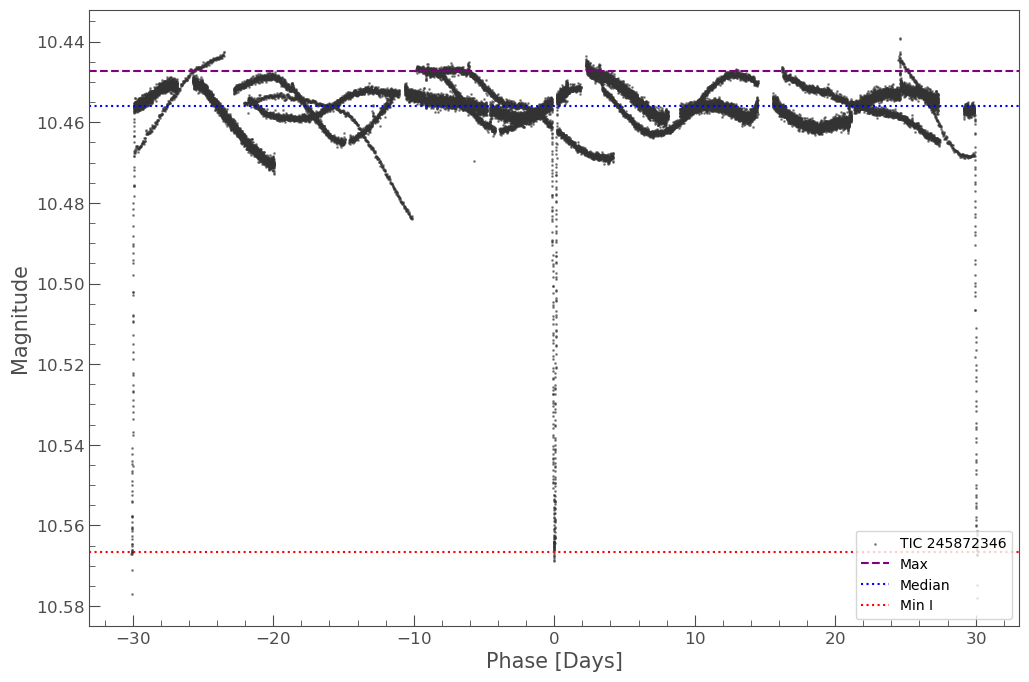

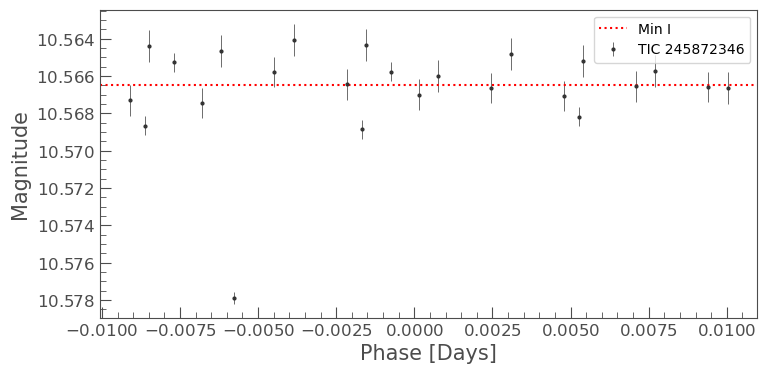

In [219]:
# %matplotlib widget
%matplotlib inline

# From TESS data

# max_flux_mag = lc.flux.min().value  #
# min_flux_mag = lc.flux.max().value
median_flux_mag = np.nanmedian(lc.flux.value)

# lc_zoom_max = lc.fold(epoch_time=epoch_time_hjd_final + 0.75, period=period_final).truncate(0 - 1 /24/60, 0 + 1 /24/ 60)  
# print("Max mag # num data points:", len(lc_zoom_max))
# max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)
max_flux_mag = np.nanpercentile(lc.flux.value, 2)


lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final).truncate(0 - 15 /24/60, 0 + 15 /24/ 60)
print("Min I mag # num data points:", len(lc_zoom_min))
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)

# lc_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd_final, period=period_final).truncate(0 - 1 /24/60, 0 + 1 /24/ 60)
# print("Min II mag # num data points:", len(lc_zoom_min_ii))
# min_ii_flux_mag = np.nanmedian(lc_zoom_min_ii.flux.value)


lc_f = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final * 2)  # 2x period plot
ax = tplt.lk_ax(figsize=(12, 8))
ax = tplt.scatter(lc_f, ax=ax, alpha=0.5);
ax.axhline(max_flux_mag, c="purple", linestyle="--", label="Max")
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.axhline(min_ii_flux_mag, c="orange", linestyle="dotted", label="Min II")
ax.legend(loc="lower right");
# ax.set_xlim(-0.5, 0.5); 
# ax.set_ylim(*ylim);

# ax = tplt.errorbar(lc_zoom_max, marker="o");
# ax.axhline(max_flux_mag, c="purple", linestyle="--", label="Max")
# # ax.set_ylim(*ylim);
# ax.legend();

ax = tplt.errorbar(lc_zoom_min, marker="o");
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.set_ylim(*ylim);
ax.legend();

# ax = tplt.errorbar(lc_zoom_min_ii, marker="o");
# ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
# ax.legend(loc="lower right");

print([f"{v:.4f}" for v in [max_flux_mag, median_flux_mag, min_flux_mag]])  # , min_ii_flux_mag


# # TESS only data, to report mean V mag and ampitude in TESS
# mean_flux_v_mag = np.round(rs_all_cols["Vmag"][0], 2)  # V converted from Gaia DR3 - here I use other sources

amp_flux_mag = np.round(np.abs(float(min_flux_mag - max_flux_mag)) , 2)  # in TESS band, don't have precision of 3 digits due to some uncertainity in the max

amp_min_i_flux_mag = np.round(np.abs(float(min_flux_mag - median_flux_mag)) , 3)  

# amp_min_ii_flux_mag = np.round(np.abs(float(min_ii_flux_mag - median_flux_mag)) , 3)  

(amp_flux_mag, amp_min_i_flux_mag )  #   , amp_min_ii_flux_mag

### Rotational Ampltiude (TESS)

0.01


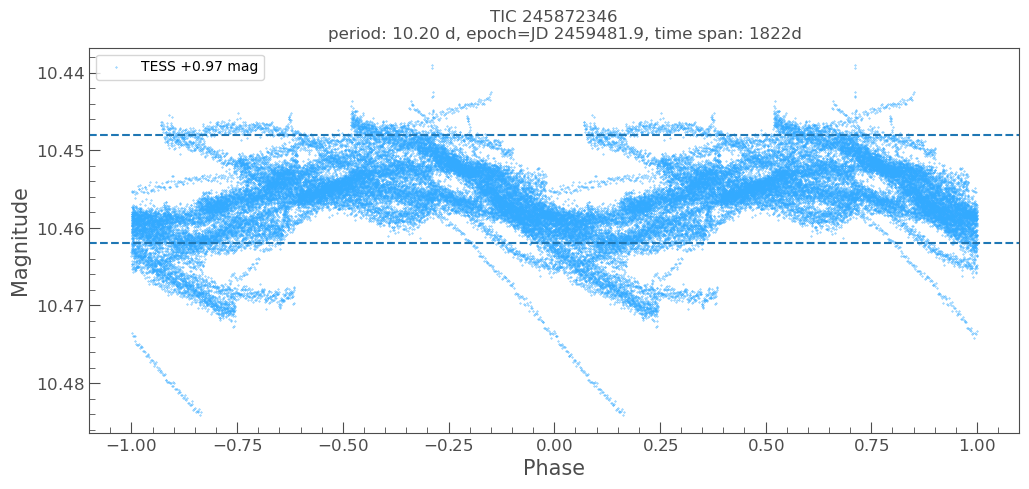

In [156]:
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    {"TESS": lc_combined_dict_no_ecl["TESS"]},
    period=rot_period_final, # shorter period, around 2.9207, would make MASCARA and TESS data fit better, but at the expanse of Hipparocos, and TESS-only data
    epoch=Time(rot_epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(12, 5),
    target_name=primary_name,
    # plot_options=plot_options,
);

rot_max_flux_mag, rot_min_flux_mag = 10.448, 10.462
ax.axhline(rot_max_flux_mag, ls="--", label="max ROT");
ax.axhline(rot_min_flux_mag, ls="--", label="min ROT");

amp_rot_flux_mag = round(rot_min_flux_mag - rot_max_flux_mag,2)
print(amp_rot_flux_mag)

## Plots for VSX

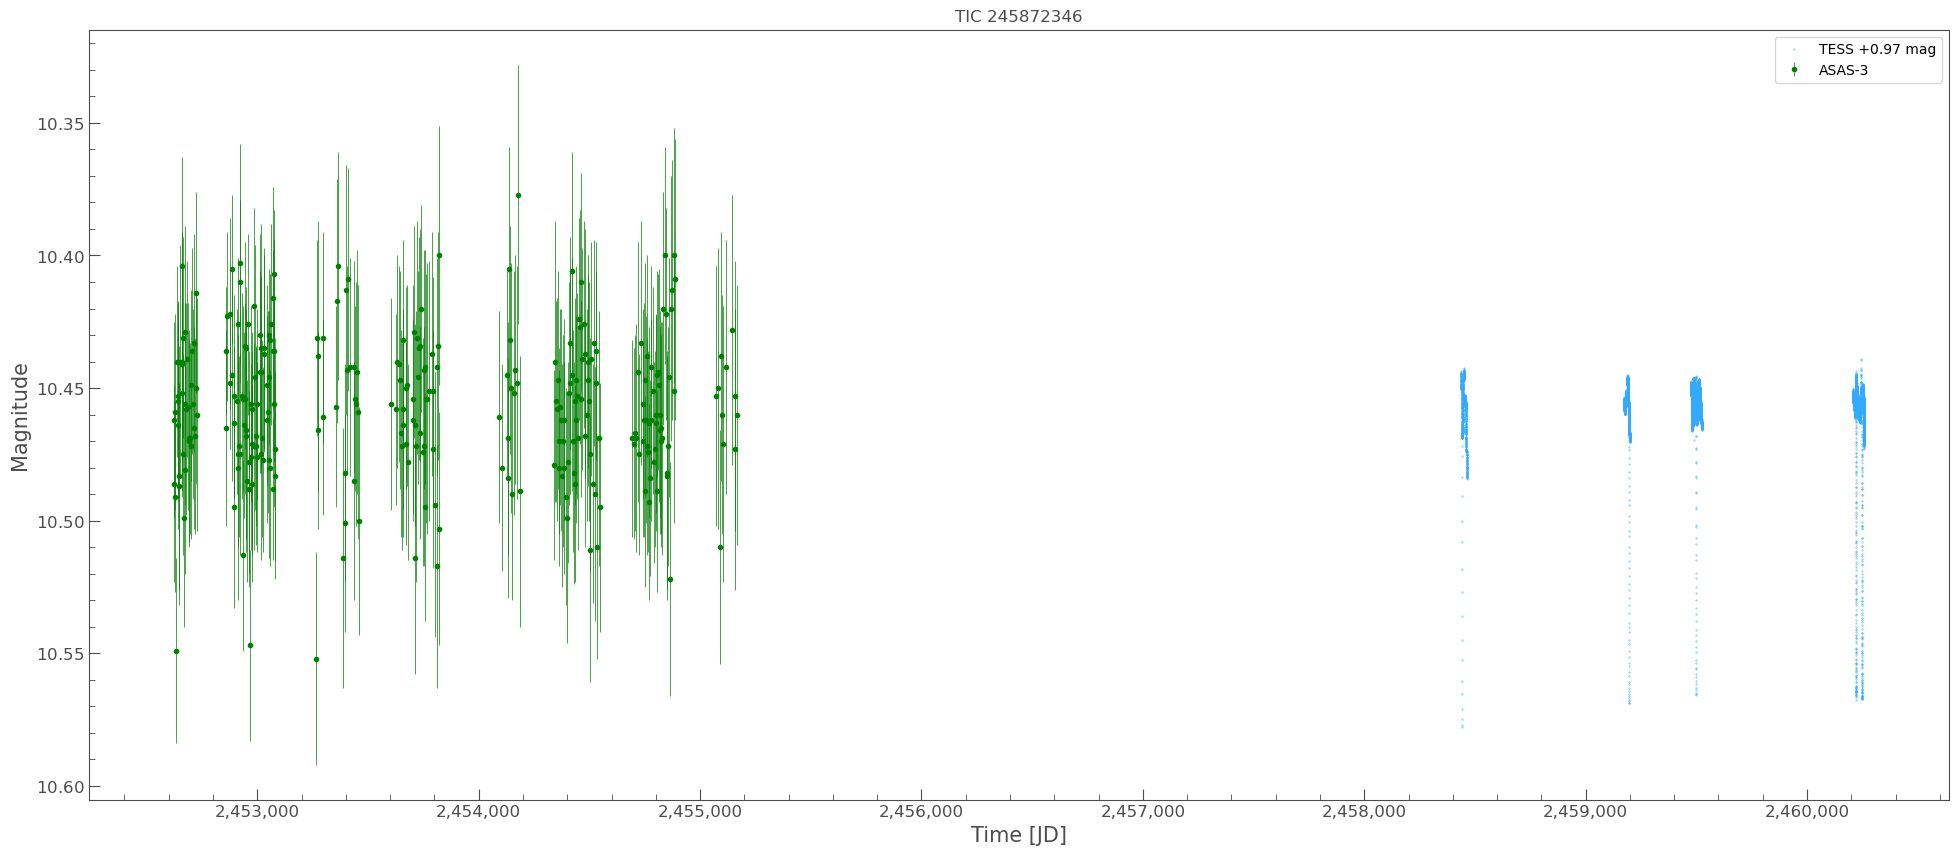

In [157]:
# reload(lkem)
# Not needed
plot_options = lkem.get_default_plot_multi_bands_options_copy()
# plot_options[0][1]["zorder"] = 4

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(24, 10), target_name=primary_name, plot_options=plot_options);
# ax.set_title(ax.get_title() + "");

#### Phase Plot (EA)



In [175]:
lkem.get_default_plot_multi_bands_options_copy()

[('scatter', {'c': '#3AF', 's': 0.1, 'alpha': 1.0}),
 ('errorbar', {'marker': '.', 'c': 'green', 'linewidth': 0.5, 'ls': 'none'}),
 ('errorbar', {'marker': '.', 'c': 'pink', 'linewidth': 0.5, 'ls': 'none'}),
 ('errorbar', {'marker': '.', 'c': 'violet', 'linewidth': 0.5, 'ls': 'none'}),
 ('errorbar', {'marker': '.', 'c': 'orange', 'linewidth': 0.5, 'ls': 'none'})]

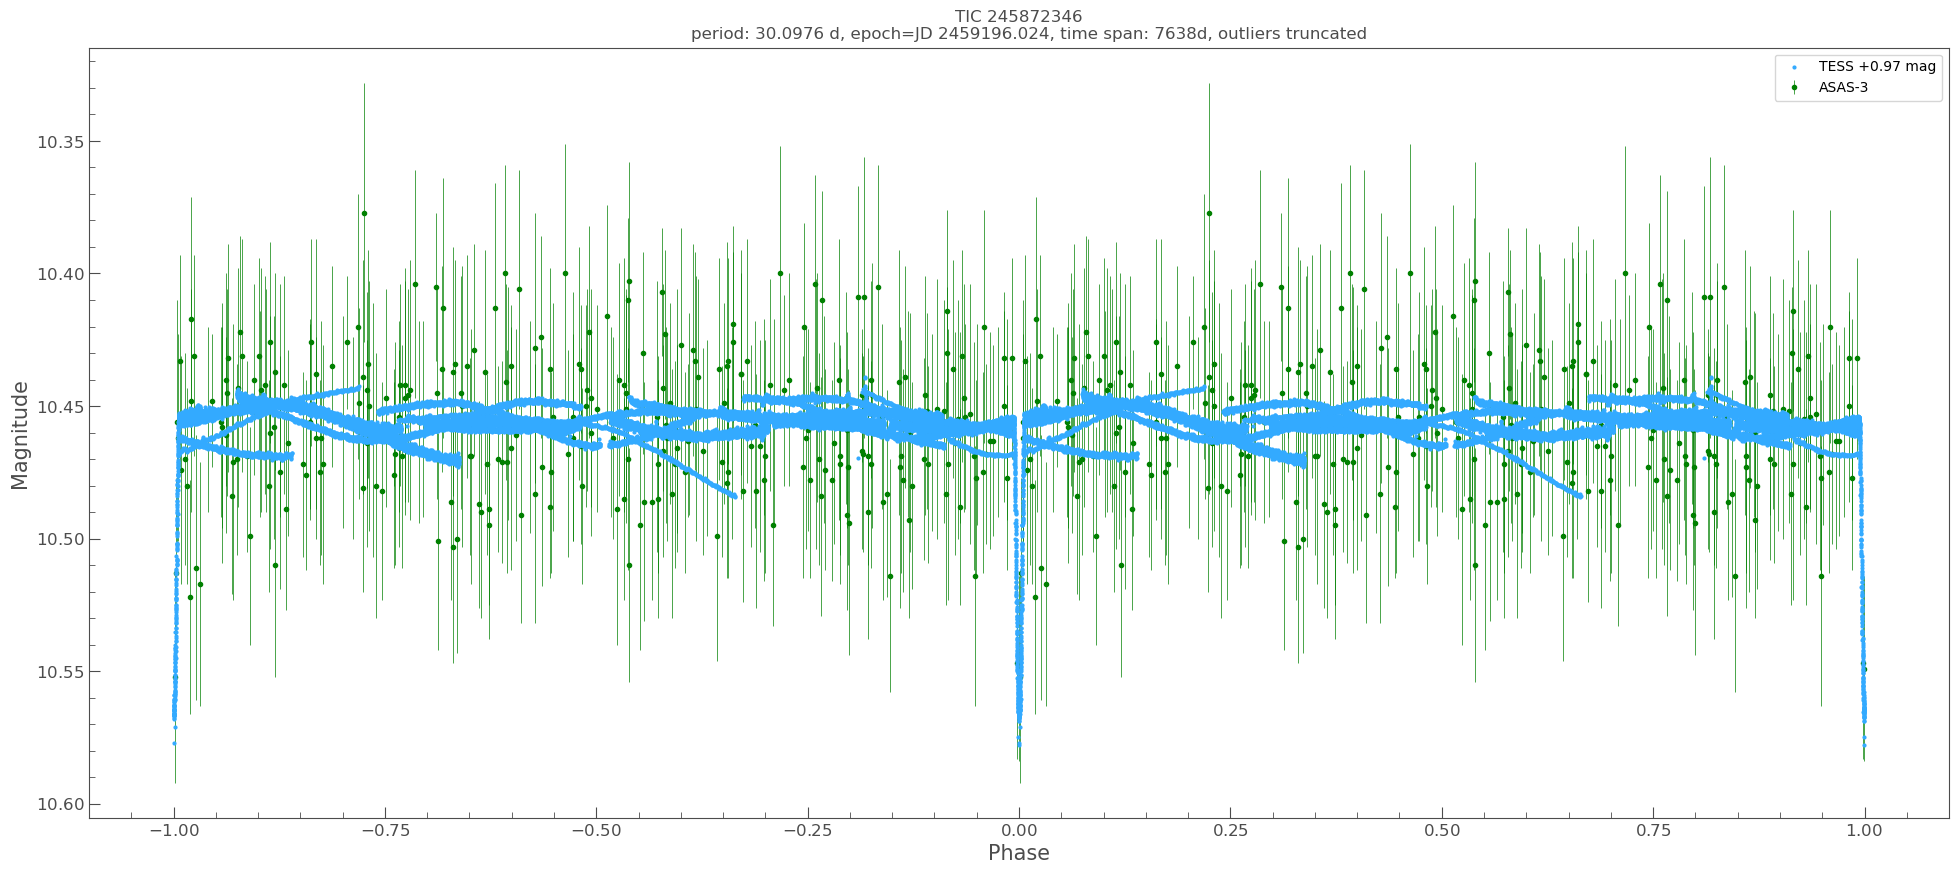

In [164]:
# reload(lkem)

plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[0][1]["zorder"] = 3  # default 2
plot_options[0][1]["s"] = 4  # to make the (narrow) eclipses more visible
# plot_options[1] = ('scatter', {'c': 'green', 's': 1, 'alpha': 1.0})  # the error for SupeWARSP is so large that it distracts the plot

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ylim = (None, None)
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + ", outliers truncated");


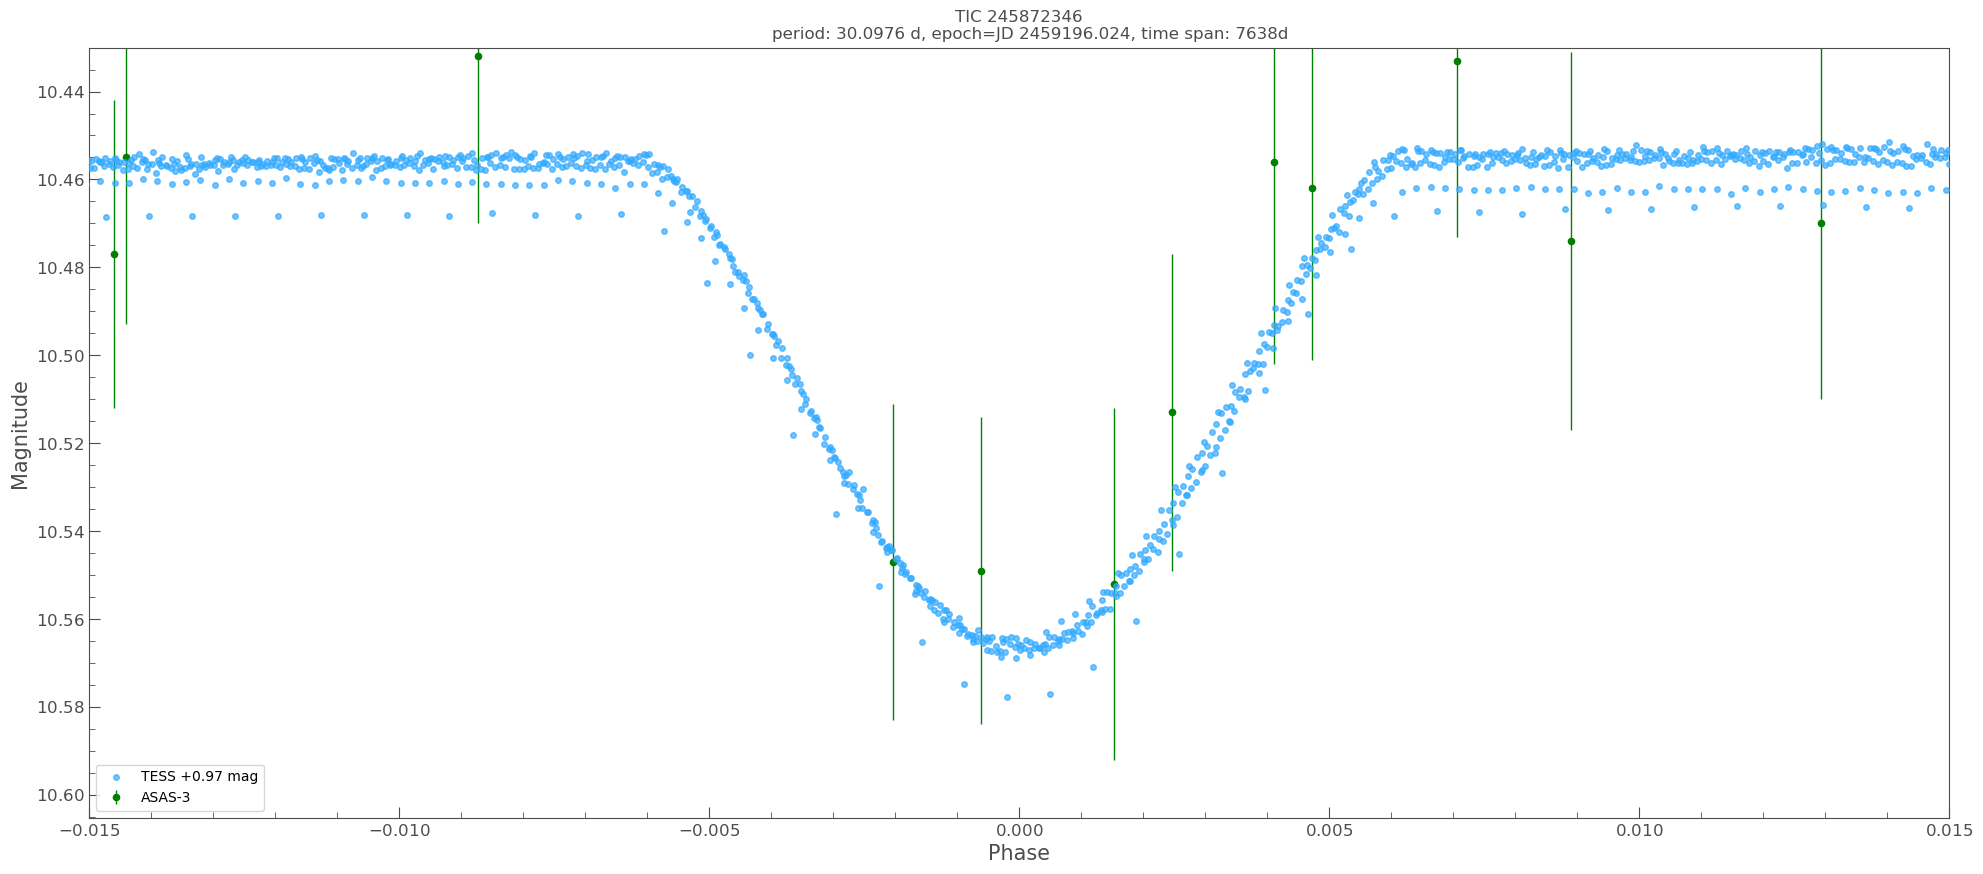

In [173]:

# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 16 # larger dots
plot_options_zoom[0][1]["zorder"] = 3  # default 2
plot_options_zoom[0][1]["alpha"] = 0.7
plot_options_zoom[1] =  ('errorbar', {'marker': '.', 'c': 'green', 'linewidth': 1, 'markersize': 9, 'ls': 'none'})
 


ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(24, 10),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ylim = (None, 10.43)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
# ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.015, 0.015);  # to see primary in details
# ax.set_xlim(-0.02, 0.02); 
# ax.set_xlim(-0.007, 0.007);  # to see primary in further details


# # zoom plot - Min II
# ax, lc_f_res = lkem.fold_n_plot_multi_bands(
#     # lc_combined_dict,
#     dict(TESS=_lc), 
#     period=period_final  ,
#     epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
#     phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
#     target_name=primary_name,
#     # duration_hr=duration_hr_min_ii_final  ,  # for plotting only
#     duration_midpoint_phase=epoch_phase_min_ii_final  ,
#     plot_options=plot_options_zoom,
#     figsize=(24, 10),
#     # mag_shift_precision=2,  #
# );
# ax.set_ylim(*ylim);
# ax.legend(loc="lower left");
# ax.set_xlim(epoch_phase_min_ii_final  -0.07, epoch_phase_min_ii_final  +0.07);  # to see Min II in details


### JD Plot (for rotational variability)

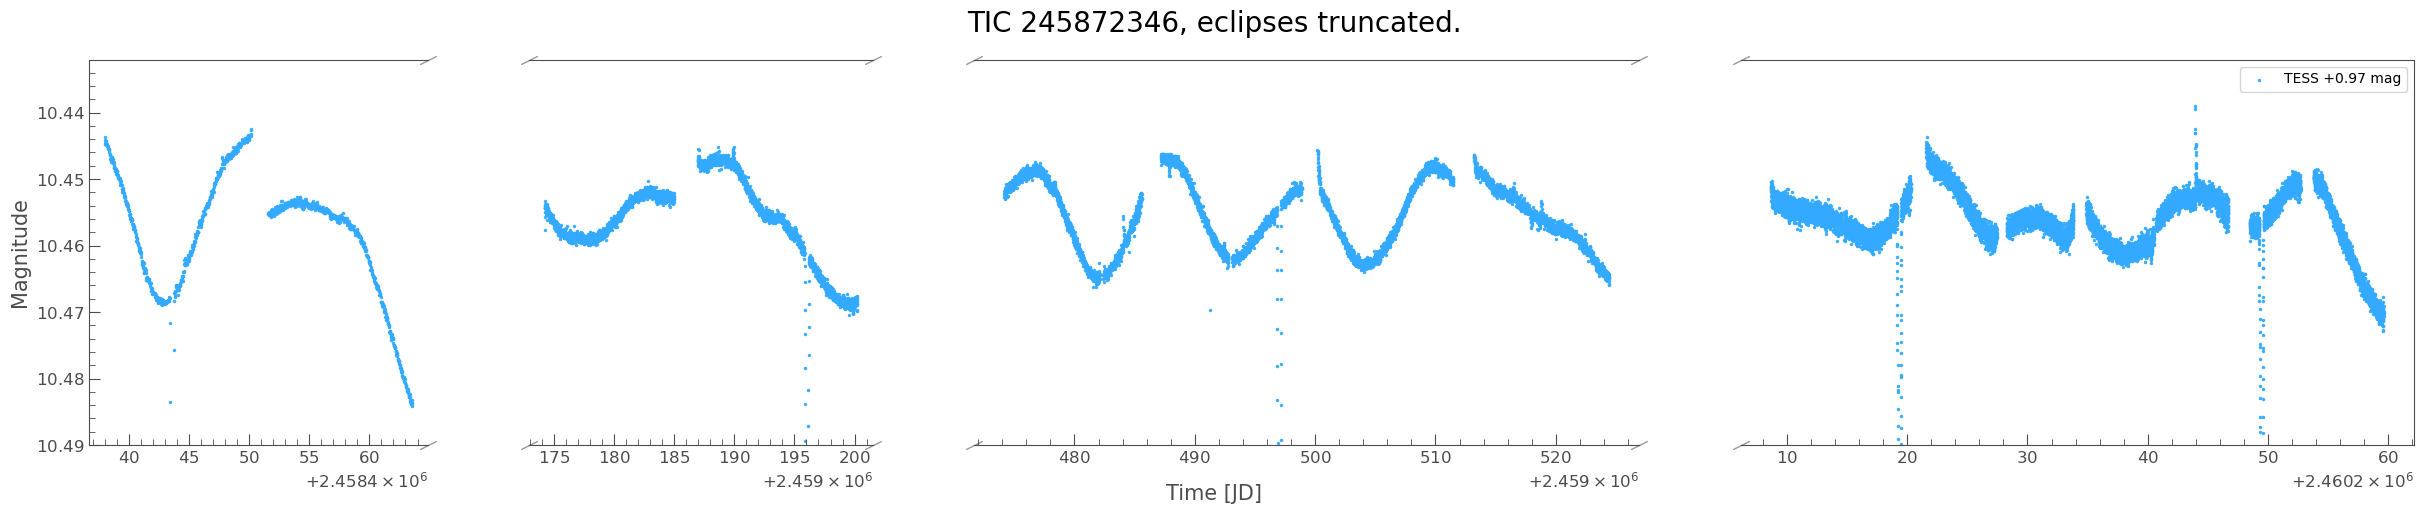

In [189]:
axs = tplt.plot_skip_data_gap(lc_combined_dict["TESS"], figsize=(30,5), s=9, alpha=0.9, c='#3AF', label=lkem.get_label_of_source(lc_combined_dict, "TESS", mag_shift_precision=2));
axs[0].get_figure().suptitle(f"{primary_name}, eclipses truncated.", fontsize=20);
[ax.set_ylim(10.49, None) for ax in axs];

### Phase Plot (ROT)

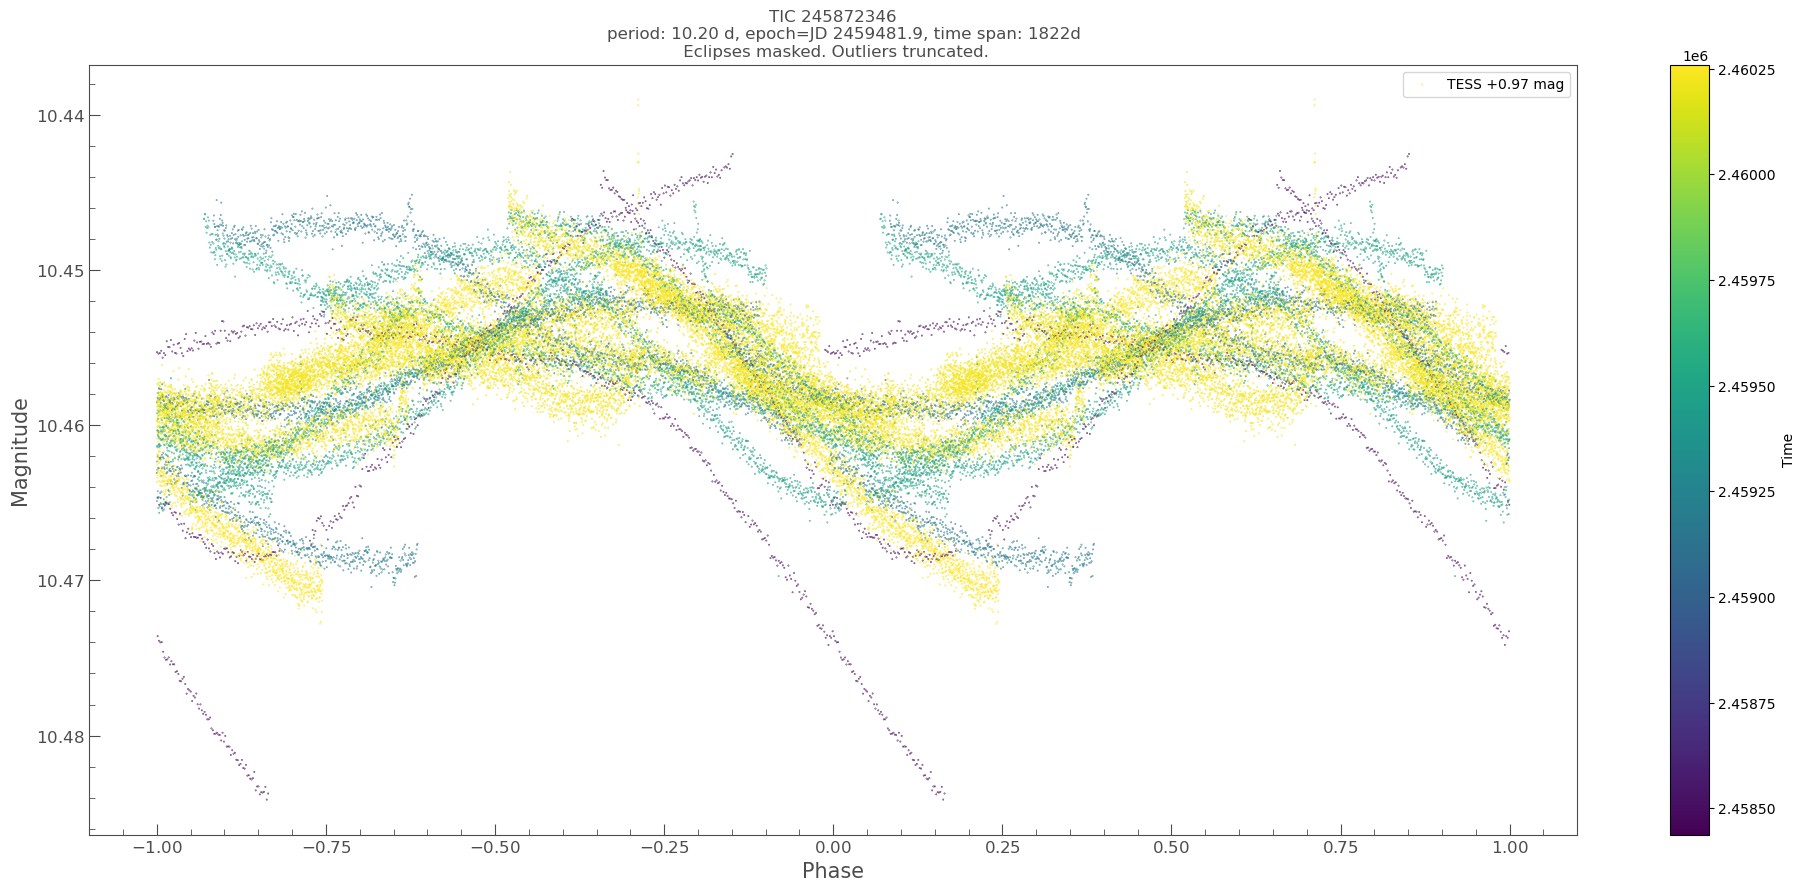

In [184]:
# TESS
# reload(lkem)

# custom options so that the scheme used here (TESS = HIP) is consistent with the combined plot
plot_options_t = lkem.get_default_plot_multi_bands_options_copy()
plot_options_t[0][1]["zorder"] = 8  # push TESS data to the near the top
plot_options_t[0][1]["c"] = "_time_"  # magic keyword to use `lc_f.time_original.value` as color

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    {"TESS": lc_combined_dict_no_ecl["TESS"]},
    period=rot_period_final,
    epoch=Time(rot_epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options_t,
);
# ax.set_ylim(7.13, 7.08);
ax.set_title(ax.get_title() + "\n Eclipses masked. Outliers truncated.");

### Zoom-in plot for one flare

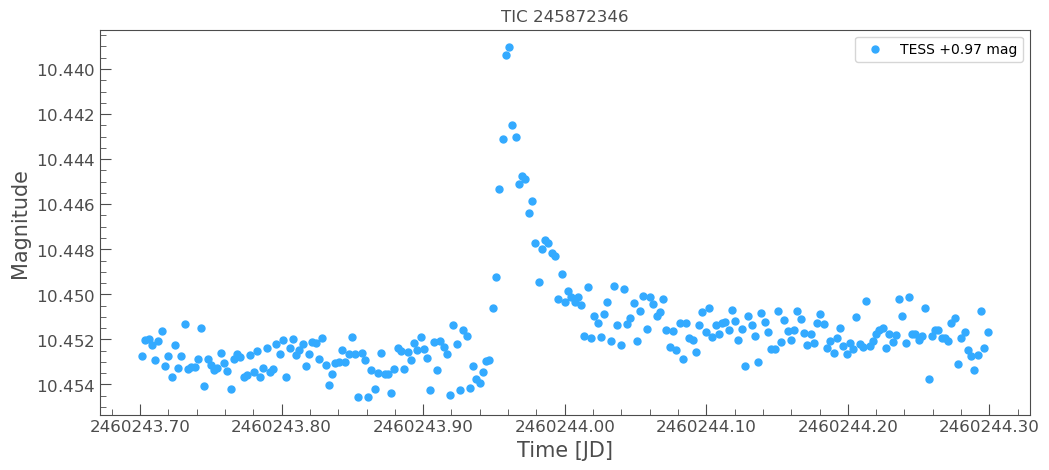

In [202]:
from matplotlib.ticker import FuncFormatter

plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[0][1]["s"] = 25

# one flare around BTJD 3243.93 in sector 71
ax = lkem.plot_multi_bands({"TESS": lc_combined_dict["TESS"].truncate(2460243.7, 2460244.3)}, figsize=(12, 5), target_name=primary_name, plot_options=plot_options);
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x:.2f}"))   # override to show decimal points in time
# ax.set_title(ax.get_title() + "");

# amp_flare_flux_mag

## VSX Report Table

In [203]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df


def vsx_phase(phase):
    # the phase I used above is from [-0.5, +0.5]
    # convert to the phase [0, 1[ used by VSX
    if phase < -0.5 or phase > 0.5:
        raise ValueError(f"Input phase needs to be in [-0.5, 0.5] range. Actual: {phase}")
    if phase >= 0:
        return phase 
    else: 
        return 1 + phase


In [222]:
import bibs_utils
# reload(bibs_utils)

other_names = f"TYC 694-877-1,2MASS J04355271+1336025"  # ExoFOP  and  SIMBAD
other_names += ",ASAS 043553+1336.0"  # ASAS-3 data
other_names += ",HD 286879,BD+13 698,GSC 00694-00877"  # -- other useful names in SIMBAD

remarks = (
    f"""Eclipse Min I amplitude: {amp_min_i_flux_mag} TESS. Period might be twice the given. """
    f"""ROT elements: HJD {rot_epoch_time_hjd_final:.2f} + {rot_period_final} x E , amplitude {amp_rot_flux_mag} TESS. ROT classification is uncertain. """ 
    f"""One flare of amplitude 0.014 TESS. """
)

# Type, period, epoch, amplitudes, and eclipse duration from TESS and ASAS-3 data. ROT params from ASAS-3 data
revision_comment = "Max magnitude from ASAS-3 data. Spectral type from 1995A&AS..110..367N . Position from Gaia DR3."


BIBS = bibs_utils.BIBS
vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    Variable_Type="EA+ROT:",
    Spectral_Type="G5", # via SIMBAD -- https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-source=III/182&HD=286879&-sort=_r&-order=I
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"{max_flux_vmag}",  # from ASAS-3 data above
    Maximum_Magnitude_band="V",
    Minimum_Magnitude=f"{amp_flux_mag}",   # in TESS from the plot above
    Minimum_Magnitude_band="TESS",  
    Minimum_Is_Amplitude=True,
    Period=f"{period_final}",  
    Epoch=f"{epoch_time_hjd_final:}",  
    Rise_Duration_Pct=f"{100 * duration_hr_min_i_final / 24 / period_final:.1f}",
    Discoverer="Sam Lee, Planet Hunters TESS Collaboration",  # PHT Talk: https://www.zooniverse.org/projects/nora-dot-eisner/planet-hunters-tess/talk/subjects/94818095, https://www.zooniverse.org/projects/nora-dot-eisner/planet-hunters-tess/talk/search?query=TIC%20245872346
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference0_Name=BIBS.QLP_N,
    Reference0_Bib=BIBS.QLP_B,
    Reference1_Name=BIBS.ASAS3_N,
    Reference1_Bib=BIBS.ASAS3_B,
    Reference2_Name="Nesterov, V. V.; et al., 1995, The Henry Draper Extension Charts: A catalogue of accurate positions, proper motions, magnitudes and spectral types of 86933 stars",
    Reference2_Bib="1995A&AS..110..367N",
)


def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))


print("""
tic245872346_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from TESS QLP and ASAS-3 data, shifted to ASAS-3, outliers and TESS systematics removed.
tic245872346_phase_plot_eclipses_min_i.png : EA Phase Plot (Min I zoom)- EA Phase Plot, zoomed to Min I.
tic245872346_phase_plot_rot_tess.png : Rotational Phase Plot - Rotational Phase Plot from TESS QLP data, eclipses masked. Outliers and systematics removed.
tic245872346_jd_plot_tess.png : TESS light curve - TESS QLP light curve, eclipses truncated. Outliers and systematics removed.
tic245872346_jd_plot_flare_zoom_tess.png: Flare Plot (Zoom) - TESS QLP light curve. Zoomed around the flare.
""")


Other Names (1 line each):
TYC 694-877-1
2MASS J04355271+1336025
ASAS 043553+1336.0
HD 286879
BD+13 698
GSC 00694-00877

Eclipse Min I amplitude: 0.11 TESS. Period might be twice the given. ROT elements: HJD 2459481.90 + 10.20 x E , amplitude 0.01 TESS. ROT classification is uncertain. One flare of amplitude 0.014 TESS. 

Max magnitude from ASAS-3 data. Spectral type from 1995A&AS..110..367N . Position from Gaia DR3.


Field  \
0                  Position   
1              Primary_Name   
2               Other_Names   
3             Variable_Type   
4             Spectral_Type   
5   Spectral_Type_Uncertain   
6         Maximum_Magnitude   
7    Maximum_Magnitude_band   
8         Minimum_Magnitude   
9    Minimum_Magnitude_band   
10     Minimum_Is_Amplitude   
11                   Period   
12                    Epoch   
13        Rise_Duration_Pct   
14               Discoverer   
15                  Remarks   
16         Revision_Comment   
17          Reference0_Name   
18           Reference0_Bib   
19          Reference1_Name   
20           Reference1_Bib   
21          Reference2_Name   
22           Reference2_Bib   

                                                                                                                                                                                                        Value  
0                                                                                                                                                                              68.96968110185, 13.60072460346  
1                                                                                                                                                                                               TIC 245872346  
2                                                                                                                TYC 694-877-1,2MASS J04355271+1336025,ASAS 043553+1336.0,HD 286879,BD+13 698,GSC 00694-00877  
3                                                                                                                                                                                                     EA+ROT:  
4                                                                                                                                                                                                          G5  
5                                                                                                                                                                                                       False  
6                                                                                                                                                                                                       10.43  
7                                                                                                                                                                                                           V  
8                                                                                                                                                                                                        0.12  
9                                                                                                                                                                                                        TESS  
10                                                                                                                                                                                                       True  
11                                                                                                                                                                                                    30.0976  
12                                                                                                                                                                                                2459196.024  
13                                                                                                                                                                                                        1.2  
14                                                                                                                                                           


tic245872346_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from TESS QLP and ASAS-3 data, shifted to ASAS-3, outliers and TESS systematics removed.
tic245872346_phase_plot_eclipses_min_i.png : EA Phase Plot (Min I zoom)- EA Phase Plot, zoomed to Min I.
tic245872346_phase_plot_rot_tess.png : Rotational Phase Plot - Rotational Phase Plot from TESS QLP data, eclipses masked. Outliers and systematics removed.
tic245872346_jd_plot_tess.png : TESS light curve - TESS QLP light curve, eclipses truncated. Outliers and systematics removed.
tic245872346_jd_plot_flare_zoom_tess.png: Flare Plot (Zoom) - TESS QLP light curve. Zoomed around the flare.

